### Faculdade de Engenharia Industrial - FEI

### Centro Universitário da Fundação Educacional Inaciana "Padre Sabóia de Medeiros" (FEI)


*FEI's Stricto Sensu Graduate Program in Electrical Engineering*

Concentration area: ARTIFICIAL INTELLIGENCE APPLIED TO AUTOMATION AND ROBOTICS

Master's thesis student Andre Luiz Florentino

***

## Check for GPU

In [60]:
import tensorflow as tf
print(tf.__version__)

pd = tf.config.experimental.list_physical_devices()
for i in pd:
    print(i)
print('------------------------------------------------------------------------------------------')


print(tf.config.list_physical_devices('GPU'))
# [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

print(tf.test.is_built_with_cuda)
# <function is_built_with_cuda at 0x000001AA24AFEC10>

print(tf.test.gpu_device_name())
# /device:GPU:0

#gvd = tf.config.get_visible_devices()
for j in tf.config.get_visible_devices():
    print(j)
# PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
# PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

#physical_devices = tf.config.experimental.list_physical_devices()
#tf.config.experimental.set_memory_growth(physical_devices[2], True)

2.3.0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')
------------------------------------------------------------------------------------------
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
<function is_built_with_cuda at 0x000001F779DB90D0>
/device:GPU:0
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# Chapter 9: Convolutional Neural Network (2D)

***

- The paper entitled "ESC-ConvNet: Environmental Sound Classification with Convolutional Neural Networks" (PICZAK, 2015) serves as the foundation for the following analysis. In this study, the author employs Convolutional Neural Networks (CNNs) for image classification, utilizing fixed dimension images that consist of multiple channels (such as RGB for color images). The network undergoes various stages of convolution, pooling, and fully connected layers, ultimately outputting class probabilities for the given image. With the aim to replicate this approach using sound clips, the utilization of log-scaled mel-spectrograms and their respective deltas from each sound clip is proposed instead of directly using the sound file as an amplitude vs. time signal. In order to address the requirement of fixed size input, the sound clips are segmented into 60x41 segments (60 bands and 44 frames - windowing techinique). The log-scaled mel-spectrograms are extracted from all the recordings, which were resampled to 22050 Hz and normalized with a window size of 1024, a hop length of 512, and 60 mel-bands.

- The human auditory system perceives sound on a logarithmic scale, rendering it difficult to distinguish closely-scaled frequencies. This effect becomes more pronounced with increasing frequency. Therefore, only the power within different frequency bands is considered. As a result, the mel-spectrograms and their corresponding deltas are transformed into two channels that are subsequently inputted into the CNN for analysis.

- During the iterative process of file exploration, it was noticed that each sound is 4, 5 or 10 seconds in duration and has in its duration (sometimes) silent periods. In order to achieve a more representative "sound image", for each sound, the "extract_feature" methods are utilized to trim the silent periods and duplicate the sound, effectively doubling its trimmed length (augmented audio). Subsequently, the aforementioned features, along with the class labels, are calculated and appended to arrays.

- The final result transformed the audio file into a spectrogram image consisting of 60 bands, 44 frames, and 2 channels. After a few cross-validations, it was confirmed the accuracy has improved when the deltas are aggreated to the image instead of using them as channels, therefore, the final image dimension was 180 (60 mels, 60 delta 1 and 60 delta 2) x 44 frames. 

## Import modules

In [61]:
import librosa
import librosa.display
import os
import warnings
import pickle
import itertools
import mimetypes
import time

import pandas     as pd
import seaborn    as sns
import numpy      as np

from matplotlib  import pyplot  as plt
from keras       import backend as K

from tqdm                        import tqdm

from sklearn                     import metrics
from sklearn.model_selection     import train_test_split
from sklearn.metrics             import confusion_matrix, classification_report

from tensorflow                  import keras
from tensorflow.keras.models     import Sequential, load_model
from tensorflow.keras.layers     import Dense, Dropout, Flatten, InputLayer, Conv2D
from tensorflow.keras.layers     import MaxPooling2D, BatchNormalization, Activation

from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks             import ModelCheckpoint, EarlyStopping
from keras.optimizers            import SGD
from keras.constraints           import maxnorm

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 12)
pd.set_option('display.width', 300)
pd.set_option('display.max_colwidth', 120)

cmap_cm   = plt.cm.Blues

In [62]:
# Globals
current_path = os.getcwd()

# For the picture names
pic_first_name = '09_CNN_2D_'

# For Librosa
FRAME_SIZE  = 1024
HOP_LENGTH  = 512
SEED        = 1000
SR          = 22050

## Loading the dataset

In [63]:
# Select the dataset

opcD = 0
while str(opcD) not in '1234':
    print()
    print("1-) ESC-10")
    print("2-) BDLib2")
    print("3-) US8K")
    print("4-) US8K_AV")

    opcD = input("\nSelect the dataset: ")
    if opcD.isdigit():
        opcD = int(opcD)
    else:
        opcD = 0

if opcD == 1:

    path        = os.path.join(current_path, "_dataset", "ESC-10")
    path_pic    = os.path.join(current_path, "ESC-10_results")
    path_models = os.path.join(current_path, "ESC-10_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)
   
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'ESC-10' 
    csv_file    = 'ESC-10.csv'
    fold        = 1
    dog_set     = 'Dog bark'
    
    pkl_features_CNN_2D          = 'ESC-10_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'ESC-10_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'ESC-10_features_CNN_2D_augmented.pkl'
    

    
if opcD == 2:
    
    path        = os.path.join(current_path, "_dataset", "BDLib2")
    path_pic    = os.path.join(current_path, "BDLib2_results")
    path_models = os.path.join(current_path, "BDLib2_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)

    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'BDLib2' 
    csv_file    = 'BDLib2.csv'
    fold        = 'fold-1'
    dog_set     = 'dogs'
    
    pkl_features_CNN_2D          = 'BDLib2_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'BDLib2_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'BDLib2_features_CNN_2D_augmented.pkl'
    
    
if opcD == 3:
    
    path        = os.path.join(current_path, "_dataset", "US8K")
    path_pic    = os.path.join(current_path, "US8K_results")
    path_models = os.path.join(current_path, "US8K_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)
        
    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K' 
    csv_file    = 'US8K.csv'
    fold        = '1'
    dog_set     = 'dog_bark'

    pkl_features_CNN_2D          = 'US8K_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'US8K_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'US8K_features_CNN_2D_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large
    
    
if opcD == 4:

    path        = os.path.join(current_path, "_dataset", "US8K_AV")
    path_pic    = os.path.join(current_path, "US8K_AV_results")
    path_models = os.path.join(current_path, "US8K_AV_saved_models")
    
    # Check if the folder exists, if not, create it
    if not os.path.exists(path_models):
        os.makedirs(path_models)


    subfolders  = next(os.walk(path))[1]
    nom_dataset = 'US8K_AV' 
    csv_file    = 'US8K_AV.csv'
    fold        = '1'
    dog_set     = 'dog_bark'
    
    pkl_features_CNN_2D          = 'US8K_AV_features_CNN_2D_original.pkl'
    pkl_aug_features_CNN_2D      = 'US8K_AV_features_CNN_2D_augmented_no_windowing.pkl'
    pkl_aug_wind_features_CNN_2D = 'US8K_AV_features_CNN_2D_windowed.pkl' # augmented and windowed makes no sense. Dataset is already quite large


1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV

Select the dataset: 

1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV

Select the dataset: 

1-) ESC-10
2-) BDLib2
3-) US8K
4-) US8K_AV

Select the dataset: 4


In [64]:
def get_next_file_number(folder: str):
    files = [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f)) and f.startswith(pic_first_name)]
    if not files:
        return 1
    else:
        numbers = [int(f.split('.')[0].split('_')[-1]) for f in files]
        return max(numbers) + 1

In [65]:
from MT_loadDataset import loadDataset

In [66]:
loadDataset = loadDataset(path)
DB          = loadDataset.db_B

print("\nClasses:\n--------------------")
print(DB["Class_categorical"].value_counts())
print("\nTotal number of unique files..........: ", len(np.unique(DB["File_name"])))
print("Total number of AUDIO files...........: ", len(DB))
DB


Classes:
--------------------
Class_categorical
dog_bark            1000
children_playing    1000
background          1000
siren                929
car_horn             429
Name: count, dtype: int64

Total number of unique files..........:  4358
Total number of AUDIO files...........:  4358


,Fold,Folder_name,Class_OHEV,Class_categorical,File_name,Path,classID,fsID,start,end,salience
0,5,fold5,"[0, 0, 0, 1, 0]",dog_bark,100032-3-0-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100032-3-0-0.wav,3,100032,0.000000,0.317551,1
1,5,fold5,"[0, 0, 1, 0, 0]",children_playing,100263-2-0-117.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-117.wav,2,100263,58.500000,62.500000,1
2,5,fold5,"[0, 0, 1, 0, 0]",children_playing,100263-2-0-121.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-121.wav,2,100263,60.500000,64.500000,1
3,5,fold5,"[0, 0, 1, 0, 0]",children_playing,100263-2-0-126.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-126.wav,2,100263,63.000000,67.000000,1
4,5,fold5,"[0, 0, 1, 0, 0]",children_playing,100263-2-0-137.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold5\100263-2-0-137.wav,2,100263,68.500000,72.500000,1
...,...,...,...,...,...,...,...,...,...,...,...
4353,7,fold7,"[0, 1, 0, 0, 0]",car_horn,99812-1-2-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-2-0.wav,1,99812,159.522205,163.522205,2
4354,7,fold7,"[0, 1, 0, 0, 0]",car_horn,99812-1-3-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-3-0.wav,1,99812,181.142431,183.284976,2
4355,7,fold7,"[0, 1, 0, 0, 0]",car_horn,99812-1-4-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-4-0.wav,1,99812,242.691902,246.197885,2
4356,7,fold7,"[0, 1, 0, 0, 0]",car_horn,99812-1-5-0.wav,C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\_dataset\US8K\fold7\99812-1-5-0.wav,1,99812,253.209850,255.741948,2


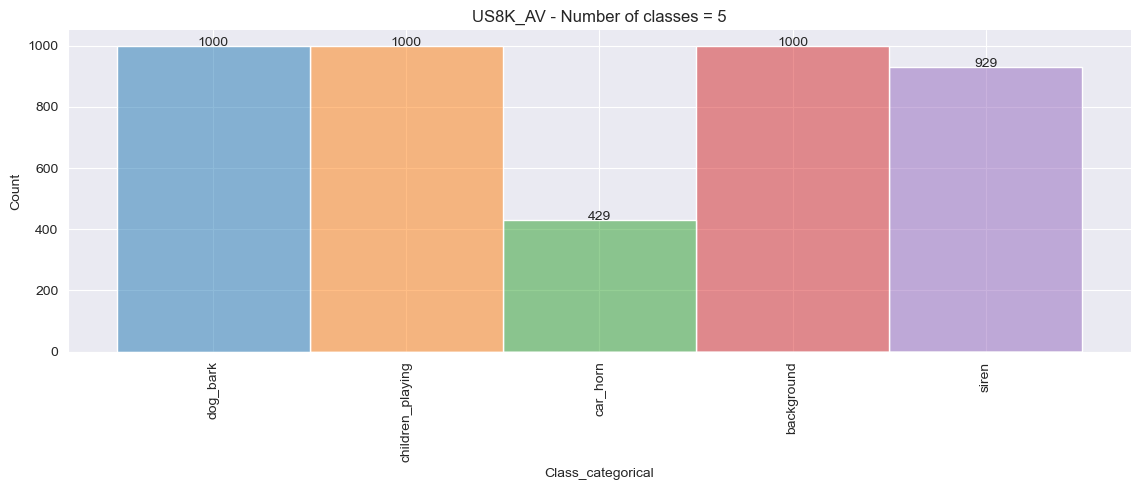

In [67]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB['Class_categorical']).unique()))
g = sns.displot(DB,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [68]:
# Read the pkl file with the augmented features extracted

opc = 0
while str(opc) not in '123':
    print()
    print("1-) Features original")
    print("2-) Features augmented")
    print("3-) Features augmented and windowed (US8K is only windowed)")

    opc = input("\nSelect the dataset: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    DB_from_pkl      = pd.read_pickle(os.path.join(path_models, pkl_features_CNN_2D))
    model_surname    = '_original'

elif opc == 2:
    DB_from_pkl      = pd.read_pickle(os.path.join(path_models, pkl_aug_features_CNN_2D))
    model_surname    = '_augmented'

elif opc == 3:
    DB_from_pkl      = pd.read_pickle(os.path.join(path_models, pkl_aug_wind_features_CNN_2D))
    model_surname    = '_windowed'
    
else:
    pass


1-) Features original
2-) Features augmented
3-) Features augmented and windowed (US8K is only windowed)

Select the dataset: 

1-) Features original
2-) Features augmented
3-) Features augmented and windowed (US8K is only windowed)

Select the dataset: 3


In [69]:
DB_from_pkl

,Class_categorical,Class_OHEV,Fold,features
0,dog_bark,"[0, 0, 0, 1, 0]",5,"[[[-44.0467643737793], [-39.25644302368164], [-38.62413787841797], [-36.58848571777344], [-32.5598030090332], [-31.4..."
1,dog_bark,"[0, 0, 0, 1, 0]",5,"[[[-29.934663772583008], [-34.787696838378906], [-40.06871795654297], [-41.22150802612305], [-41.03109359741211], [-..."
2,dog_bark,"[0, 0, 0, 1, 0]",5,"[[[-23.2158260345459], [-28.396337509155273], [-32.66521072387695], [-31.442462921142578], [-35.61741256713867], [-3..."
3,dog_bark,"[0, 0, 0, 1, 0]",5,"[[[-37.06025695800781], [-39.86629104614258], [-41.0966682434082], [-38.97296142578125], [-41.87018966674805], [-39...."
4,dog_bark,"[0, 0, 0, 1, 0]",5,"[[[-28.527423858642578], [-29.930322647094727], [-35.48342514038086], [-38.032806396484375], [-38.82895278930664], [..."
...,...,...,...,...
30501,car_horn,"[0, 1, 0, 0, 0]",7,"[[[-16.7570743560791], [-12.688139915466309], [-16.03248405456543], [-15.612970352172852], [-12.660606384277344], [-..."
30502,car_horn,"[0, 1, 0, 0, 0]",7,"[[[-14.313464164733887], [-12.228155136108398], [-15.787863731384277], [-16.082149505615234], [-12.465015411376953],..."
30503,car_horn,"[0, 1, 0, 0, 0]",7,"[[[-24.34674835205078], [-17.664506912231445], [-11.443778038024902], [-11.371871948242188], [-12.617921829223633], ..."
30504,car_horn,"[0, 1, 0, 0, 0]",7,"[[[-20.291765213012695], [-13.778326034545898], [-9.759299278259277], [-8.09199333190918], [-8.728732109069824], [-1..."


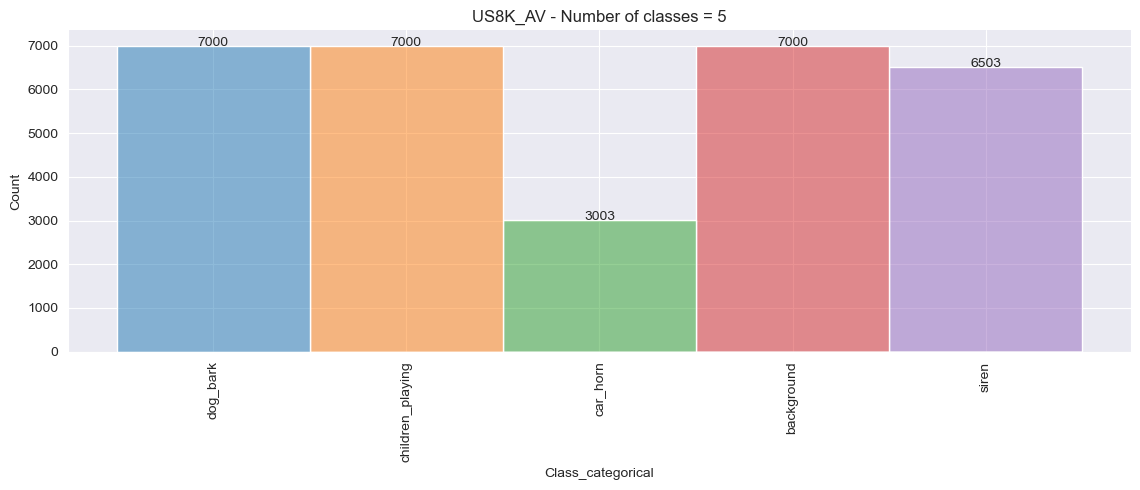

In [70]:
# Analysis of the class balancing

sns.set_style("darkgrid")
gTitle = f'{nom_dataset} - Number of classes = ' + str(len(pd.Series(DB_from_pkl['Class_categorical']).unique()))
g = sns.displot(DB_from_pkl,x='Class_categorical', hue='Class_categorical',height = 5, aspect = 2).set(title=gTitle)
g.set_xticklabels(rotation=90)
g.set_titles('Number of classes')

# Retrieve the axes object from the plot
axes = g.ax

# Iterate over each bar in the plot
for p in axes.patches:
    # Get the coordinates of the bar
    width = p.get_width()
    height = p.get_height()
    cord_x, cord_y = p.get_xy()
    if height > 0:
        axes.annotate(f'{height}', (cord_x + width/2, cord_y + height), ha='center')
        
g._legend.remove()

plt.tight_layout()

In [71]:
for fold in np.unique(DB_from_pkl['Fold']):
    print(f"Validation fold: {fold}")
    
    valsize = len(DB_from_pkl[DB_from_pkl['Fold'] == fold])
    trnsize = len(DB_from_pkl[DB_from_pkl['Fold'] != fold])
    print(f'dbComplete_VAL size: {valsize}')
    print(f'dbComplete_TRN size: {trnsize}')
    print()

Validation fold: 1
dbComplete_VAL size: 3010
dbComplete_TRN size: 27496

Validation fold: 10
dbComplete_VAL size: 2933
dbComplete_TRN size: 27573

Validation fold: 2
dbComplete_VAL size: 3003
dbComplete_TRN size: 27503

Validation fold: 3
dbComplete_VAL size: 3374
dbComplete_TRN size: 27132

Validation fold: 4
dbComplete_VAL size: 3773
dbComplete_TRN size: 26733

Validation fold: 5
dbComplete_VAL size: 3276
dbComplete_TRN size: 27230

Validation fold: 6
dbComplete_VAL size: 2800
dbComplete_TRN size: 27706

Validation fold: 7
dbComplete_VAL size: 2835
dbComplete_TRN size: 27671

Validation fold: 8
dbComplete_VAL size: 2730
dbComplete_TRN size: 27776

Validation fold: 9
dbComplete_VAL size: 2772
dbComplete_TRN size: 27734



In [82]:
# Set fold = '1' to train the model to be used in the ESR data preparation

fold = '1'
fold

'1'

In [83]:
DB_from_pkl.dtypes

Class_categorical    object
Class_OHEV           object
Fold                 object
features             object
dtype: object

In [84]:
DB_from_pkl['Class_OHEV'][0][0]

0

In [85]:
print(DB_from_pkl['Fold'].shape)
print(DB_from_pkl['Class_OHEV'][0].shape)
print(DB_from_pkl['features'][0].shape)

(30506,)
(5,)
(180, 44, 1)


In [86]:
print(type(DB_from_pkl['Fold'][0][0]))
print(type(DB_from_pkl['Class_OHEV'][0][0]))
print(type(DB_from_pkl['features'][0][0][0][0]))

<class 'str'>
<class 'numpy.int32'>
<class 'numpy.float64'>


In [87]:
# Group by the class and get one random sample of each class
k = DB_from_pkl.groupby('Class_categorical')['Class_OHEV'].apply(lambda s: s.sample(1))
print(k)

# Convert the pandas series into a dataframe
temp_k_df = k.reset_index()

# Delete the index from the grouppby result
del temp_k_df['level_1']

# Set the "Class" as the dataframe index
temp_k_df.set_index("Class_categorical", inplace=True)

# Convert the dataframe to a dictionary (Class: Class_encoder)
encoder_dict = temp_k_df["Class_OHEV"].to_dict()
encoder_dict

Class_categorical       
background         10508    [1, 0, 0, 0, 0]
car_horn           26470    [0, 1, 0, 0, 0]
children_playing   6670     [0, 0, 1, 0, 0]
dog_bark           24002    [0, 0, 0, 1, 0]
siren              18540    [0, 0, 0, 0, 1]
Name: Class_OHEV, dtype: object


{'background': array([1, 0, 0, 0, 0]),
 'car_horn': array([0, 1, 0, 0, 0]),
 'children_playing': array([0, 0, 1, 0, 0]),
 'dog_bark': array([0, 0, 0, 1, 0]),
 'siren': array([0, 0, 0, 0, 1])}

In [88]:
# Number of classes in the dataset

num_classes = len(encoder_dict.keys())
num_classes

5

In [89]:
# Name of the classes

nom_classes = list(encoder_dict.keys())
nom_classes

['background', 'car_horn', 'children_playing', 'dog_bark', 'siren']

## Input split

In [90]:
# Separate 1 fold for validation and create a DB for the training / testing

DB_from_pkl_VAL = DB_from_pkl[DB_from_pkl['Fold'] == fold].copy()
DB_from_pkl_TRN = DB_from_pkl[DB_from_pkl['Fold'] != fold].copy()

X      = DB_from_pkl_TRN['features'].to_numpy()
y      = np.array(DB_from_pkl_TRN.Class_categorical.to_list())
y_OHEV = np.array(DB_from_pkl_TRN.Class_OHEV.to_list())

X_val      = DB_from_pkl_VAL['features'].to_numpy()
y_val      = np.array(DB_from_pkl_VAL.Class_categorical.to_list())
y_OHEV_val = np.array(DB_from_pkl_VAL.Class_OHEV.to_list())


# Stackup and pass all values to float32
X = np.stack(X)
X = np.asarray(X).astype(np.float32)

X_val = np.stack(X_val)
X_val = np.asarray(X_val).astype(np.float32)

y_OHEV     = np.asarray(y_OHEV).astype(np.float32)
y_OHEV_val = np.asarray(y_OHEV_val).astype(np.float32)


# Retrieve the indexes used for training the classifiers
idx_trn = np.genfromtxt(os.path.join(path_models, '_idx_trn_' + nom_dataset + model_surname + '.csv'), delimiter=',', dtype = int)
idx_tst = np.genfromtxt(os.path.join(path_models, '_idx_tst_' + nom_dataset + model_surname + '.csv'), delimiter=',', dtype = int)

X_train      = X[idx_trn]
X_test       = X[idx_tst]
y_train      = y[idx_trn]
y_test       = y[idx_tst]
y_train_OHEV = y_OHEV[idx_trn]
y_test_OHEV  = y_OHEV[idx_tst]

In [91]:
idx_trn

array([ 5221, 26886, 26007, ...,  1207, 16801, 16613])

In [92]:
idx_tst

array([12980,  2697, 15451, ...,  5356, 21051, 12598])

In [93]:
print("\n==================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)}')
print(f'y_train.........: {np.shape(y_train)}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)}')

print("\n==================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)}')
print(f'y_test..........: {np.shape(y_test)}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)}')

print("\n==================================")
print("Validation set\n")

print(f'X_val...........: {np.shape(X_val)}')
print(f'y_val...........: {np.shape(y_val)}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)}')


Training set

X_train.........: (24746, 180, 44, 1)
y_train.........: (24746,)
y_train_OHEV....: (24746, 5)

Testing set

X_test..........: (2750, 180, 44, 1)
y_test..........: (2750,)
y_test_OHEV.....: (2750, 5)

Validation set

X_val...........: (3010, 180, 44, 1)
y_val...........: (3010,)
y_OHEV_val......: (3010, 5)


In [94]:
# Simple confusion matrix

def simple_conf_matrix(y_true, y_pred, nom_classes, clf, acc):
    
    picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

    conf_matrix = metrics.confusion_matrix(y_true, y_pred)
    title = nom_dataset + model_surname + norm_type + ' - Classifier ' + clf + ' - Validation accuracy: '+ str("{:0.2f} %".format(acc*100))

    plt.figure(figsize = (10,10))
    sns.heatmap(conf_matrix, 
                annot=True, 
                fmt='g', 
                cmap=cmap_cm, 
                annot_kws={"size": 8}, 
                xticklabels=nom_classes, 
                yticklabels=nom_classes)
    plt.title(title, fontsize = 12)
    plt.savefig(os.path.join(path_pic, picture_name))
    plt.show()

In [95]:
# Plot the confusion matrix

def plot_confusion_matrix(cm, labels, title, cmap, normalize):

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, fontsize=10, rotation=45)
        plt.yticks(tick_marks, labels, fontsize=10)
   
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black", fontsize = 8)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize=13)
    plt.colorbar(shrink=1)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(None)
    plt.tight_layout()

## Classifiers

- **Convolutional Neural Networks** (CNNs) are a class of deep learning algorithms specifically designed for processing grid-like data, such as images and videos. CNNs are highly effective in tasks related to computer vision, including image recognition, object detection, and image segmentation. They are characterized by their ability to automatically and adaptively learn spatial hierarchies of features from input data. CNNs consist of multiple layers, including convolutional layers, pooling layers, and fully connected layers. The convolutional layers apply convolution operations to the input data, enabling the network to automatically learn patterns and features from images, such as edges, textures, and more complex structures. The pooling layers downsample the spatial dimensions of the data, reducing computational complexity while retaining important features. Fully connected layers at the end of the network process the learned features and make predictions based on them. One of the significant advantages of CNNs is their ability to capture local patterns and spatial hierarchies of features. By using shared weights and biases in the convolutional layers, CNNs are capable of learning translation-invariant features, making them well-suited for tasks where the spatial arrangement of features in the input data is essential. Additionally, CNNs can automatically learn relevant features from raw pixel values, eliminating the need for manual feature extraction.

In [96]:
inputShape = X_train[0].shape
inputShape

(180, 44, 1)

In [97]:
# Architecture based on Su et al. (2019)

def basemodel_Su(model_name):
       
    model = Sequential(name = model_name)
    
    # Input is 44 x 180
    # If we have N x N image size and F x F filter size, afer the convolution the result will be
    # (N x N) * (F x F) = (N - F + 1) x (N - F + 1)
    # (44 - 7 + 1) x (180 - 7 + 1) = (38 x 174)
    
    model.add(Conv2D(32, (3, 3), input_shape=(inputShape), padding='same', strides=(2,2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), strides=(2,2), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))

    model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten(name='Flatten'))

    model.add(Dense(1024, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs  = 100
    lrate   = 0.001
    decay   = lrate/epochs
    sgd     = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

In [98]:
# Architecture based on Luz et al. (2021)

def basemodel_Luz(model_name):
       
    model = Sequential(name = model_name)
    
    model.add(Conv2D(24, (5, 5), input_shape=(inputShape), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(48, (5, 5), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(48, (5, 5), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(48, (5, 5), padding='same', strides=(1,1), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten(name='Flatten'))

    model.add(Dense(64, activation='relu', kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu', kernel_constraint=maxnorm(3)))
    
    model.add(Dense(num_classes, activation='softmax'))
    
    # Compile model
    epochs  = 100
    lrate   = 0.001
    decay   = lrate/epochs
    sgd     = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
    
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model

In [99]:
monitor = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=20, verbose=1, mode='auto', restore_best_weights=True)

if not os.path.exists(path_models):
    os.makedirs(path_models)

filepath       = os.path.join(path_models, 'Model_CNN_2D_weights_0_best' + model_surname + '.hdf5')
checkpoint     = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint, monitor]

In [100]:
# Select the model

opc = 0
while str(opc) not in '12':
    print()
    print("1-) Architecture based on Su et al. (2019)")
    print("2-) Architecture based on Luz et al. (2021)")

    opc = input("\nSelect the model: ")
    if opc.isdigit():
        opc = int(opc)
    else:
        opc = 0

if opc == 1:
    basemodel = basemodel_Su
    surName = '_Su'

elif opc == 2:
    basemodel = basemodel_Luz
    surName = '_Luz'

else:
    pass

Model_CNN_2D = basemodel('Model_CNN_2D' + surName)
print(Model_CNN_2D.summary())


1-) Architecture based on Su et al. (2019)
2-) Architecture based on Luz et al. (2021)

Select the model: 2
Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization_4 (Batch (None, 180, 44, 24)       96        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 22, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 22, 48)        28848     
_________________________________________________________________
batch_normalization_5 (Batch (None, 90, 22, 48)        192       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 11, 48)        0         
_______

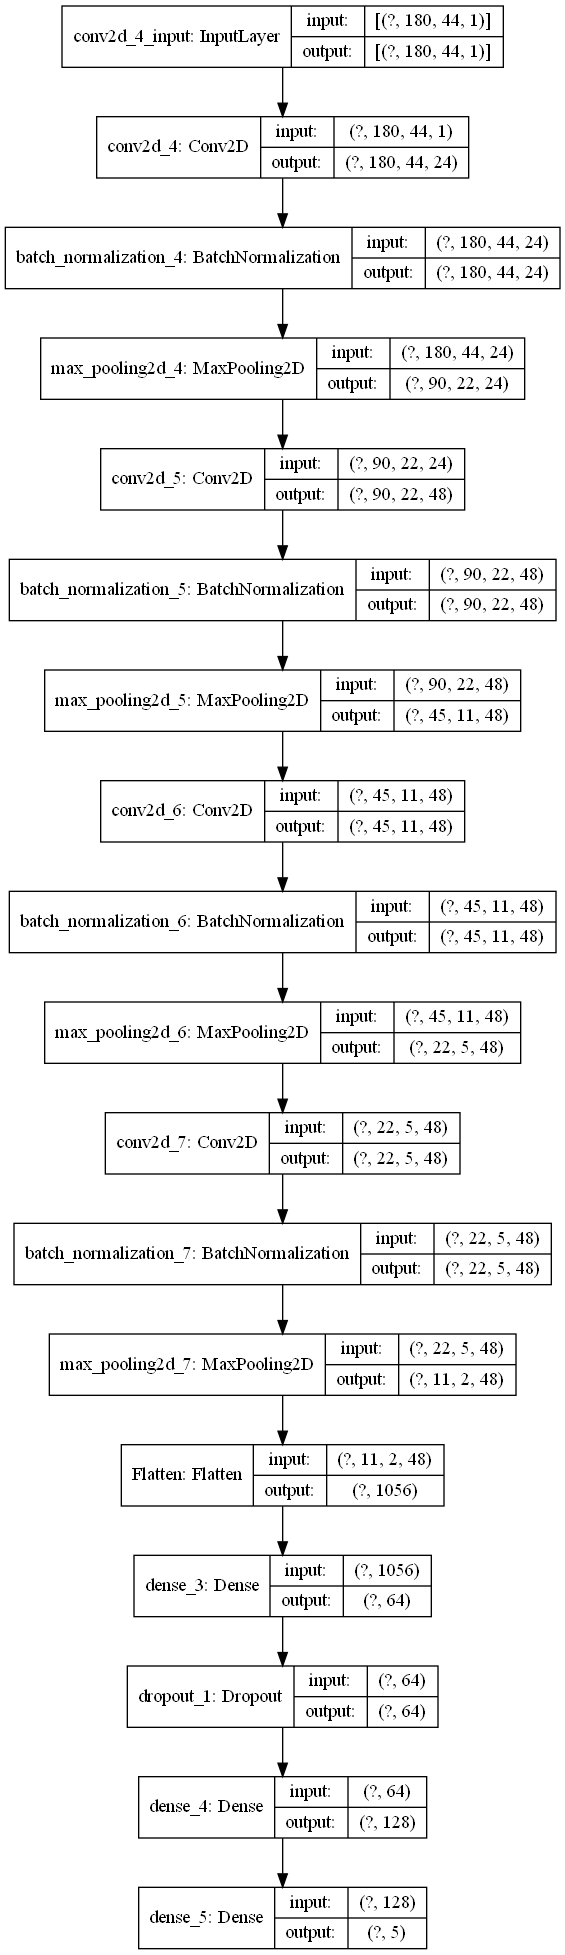

In [101]:
tf.keras.utils.plot_model(Model_CNN_2D, to_file= os.path.join(path_models, 'Model_CNN_2D' + model_surname + '.png'), show_shapes=True)

### Understanding the column "Param":

1. For `Conv1D` layer:
   - The number of parameters for a `Conv1D` layer is calculated as `(kernel_size * input_channels + 1) * output_channels`, where `kernel_size` is the size of the convolutional kernel, `input_channels` is the number of input channels (1 in this case), and `output_channels` is the number of output channels.

2. For `Dense` layer:
   - The number of parameters for a `Dense` layer is calculated as `(input_units + 1) * output_units`, where `input_units` is the number of input units and `output_units` is the number of output units.
   
3. In the calculation of parameters for a convolutional layer, the term "channels" refers to the number of filters used in that layer.
4. Params = (filter_height * filter_width * input_channels + 1) * number_of_filters


- 624   parameters is the result of 24 filters * (5 kernels * 5 kernels * 1 channel + 1)
- 28,848 parameters is the result of 48 filter * (5 kernels * 5 kernels * 24 channels + 1)
- 57,648 parameters is the result of 48 filter * (5 kernels * 5 kernels * 48 channels + 1)
- 57,648 parameters is the result of 48 filter * (5 kernels * 5 kernels * 48 channels + 1)
- 67,648  parameters is the result of 64 neurons with 1,056 features + 64 bias values
- 8,320  parameters is the result of 128 neurons with 64 features + 128 bias values
- 645  parameters is the result of 5 neurons with 128 features + 5 bias values

### CNN 2D adjustments

In [102]:
print("\n========================================================================")
print("Training set\n")

print(f'X_train.........: {np.shape(X_train)} ...type: {type(X_train[0][0][0][0])}')
print(f'y_train_OHEV....: {np.shape(y_train_OHEV)} ............type: {type(y_train_OHEV[0][0])}')

print("\n========================================================================")
print("Testing set\n")

print(f'X_test..........: {np.shape(X_test)} ....type: {type(X_test[0][0][0][0])}')
print(f'y_test_OHEV.....: {np.shape(y_test_OHEV)} .............type: {type(y_test_OHEV[0][0])}')

print("\n========================================================================")
print("Validation set\n")

print(f'X_val...........: {np.shape(X_val)} ....type: {type(X_val[0][0][0][0])}')
print(f'y_OHEV_val......: {np.shape(y_OHEV_val)} .............type: {type(y_OHEV_val[0][0])}')


Training set

X_train.........: (24746, 180, 44, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (24746, 5) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (2750, 180, 44, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (2750, 5) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3010, 180, 44, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3010, 5) .............type: <class 'numpy.float32'>


In [103]:
batch_size = 32
epochs     = 100
history    = Model_CNN_2D.fit(X_train, y_train_OHEV,
                              batch_size      = batch_size,
                              epochs          = epochs,
                              verbose         = 1,
                              validation_data = (X_test, y_test_OHEV),
                              steps_per_epoch=int(np.ceil(X_train.shape[0] / float(batch_size))),
                              callbacks       = callbacks_list,
                              use_multiprocessing = True)

Epoch 1/100
774/774 [==============================] - ETA: 0s - loss: 0.9272 - accuracy: 0.6429
Epoch 00001: val_accuracy improved from -inf to 0.79745, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_weights_0_best_windowed.hdf5
774/774 [==============================] - 139s 179ms/step - loss: 0.9272 - accuracy: 0.6429 - val_loss: 0.5483 - val_accuracy: 0.7975
Epoch 2/100
774/774 [==============================] - ETA: 0s - loss: 0.5667 - accuracy: 0.7952
Epoch 00002: val_accuracy improved from 0.79745 to 0.86509, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_weights_0_best_windowed.hdf5
774/774 [==============================] - 133s 171ms/step - loss: 0.5667 - accuracy: 0.7952 - val_loss: 0.3834 - val_accuracy: 0.8651
Epoch 3/100
774/774 [==============================] - ETA: 0s - loss: 0.4319 - accuracy: 0.8448
Epoch 00003: val_accuracy did not improve fr

Epoch 24/100
774/774 [==============================] - ETA: 0s - loss: 0.0404 - accuracy: 0.9871
Epoch 00024: val_accuracy did not improve from 0.97055
774/774 [==============================] - 128s 166ms/step - loss: 0.0404 - accuracy: 0.9871 - val_loss: 0.1063 - val_accuracy: 0.9698
Epoch 25/100
774/774 [==============================] - ETA: 0s - loss: 0.0292 - accuracy: 0.9903
Epoch 00025: val_accuracy did not improve from 0.97055
774/774 [==============================] - 129s 167ms/step - loss: 0.0292 - accuracy: 0.9903 - val_loss: 0.1501 - val_accuracy: 0.9644
Epoch 26/100
774/774 [==============================] - ETA: 0s - loss: 0.0312 - accuracy: 0.9897
Epoch 00026: val_accuracy did not improve from 0.97055
774/774 [==============================] - 129s 167ms/step - loss: 0.0312 - accuracy: 0.9897 - val_loss: 0.1409 - val_accuracy: 0.9665
Epoch 27/100
774/774 [==============================] - ETA: 0s - loss: 0.0260 - accuracy: 0.9919
Epoch 00027: val_accuracy did not impr

Epoch 52/100
774/774 [==============================] - ETA: 0s - loss: 0.0063 - accuracy: 0.9981
Epoch 00052: val_accuracy did not improve from 0.97891
774/774 [==============================] - 126s 163ms/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0.1361 - val_accuracy: 0.9767
Epoch 53/100
774/774 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9979
Epoch 00053: val_accuracy did not improve from 0.97891
774/774 [==============================] - 126s 163ms/step - loss: 0.0065 - accuracy: 0.9979 - val_loss: 0.1513 - val_accuracy: 0.9749
Epoch 54/100
774/774 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9980
Epoch 00054: val_accuracy did not improve from 0.97891
774/774 [==============================] - 126s 163ms/step - loss: 0.0069 - accuracy: 0.9980 - val_loss: 0.1367 - val_accuracy: 0.9782
Epoch 55/100
774/774 [==============================] - ETA: 0s - loss: 0.0041 - accuracy: 0.9991
Epoch 00055: val_accuracy did not impr

Epoch 80/100
774/774 [==============================] - ETA: 0s - loss: 0.0038 - accuracy: 0.9989
Epoch 00080: val_accuracy did not improve from 0.98145
774/774 [==============================] - 126s 163ms/step - loss: 0.0038 - accuracy: 0.9989 - val_loss: 0.1419 - val_accuracy: 0.9796
Epoch 81/100
774/774 [==============================] - ETA: 0s - loss: 0.0042 - accuracy: 0.9985
Epoch 00081: val_accuracy did not improve from 0.98145
774/774 [==============================] - 126s 163ms/step - loss: 0.0042 - accuracy: 0.9985 - val_loss: 0.1659 - val_accuracy: 0.9745
Epoch 82/100
774/774 [==============================] - ETA: 0s - loss: 0.0033 - accuracy: 0.9990
Epoch 00082: val_accuracy did not improve from 0.98145
774/774 [==============================] - 127s 164ms/step - loss: 0.0033 - accuracy: 0.9990 - val_loss: 0.1341 - val_accuracy: 0.9775
Epoch 83/100
774/774 [==============================] - ETA: 0s - loss: 0.0021 - accuracy: 0.9994
Epoch 00083: val_accuracy did not impr

In [104]:
score_CNN_2D = Model_CNN_2D.evaluate(X_val, y_OHEV_val, verbose=1, batch_size = batch_size)
print('Test loss:', score_CNN_2D[0])
print('Test accuracy:', score_CNN_2D[1])

95/95 [==============================] - 4s 44ms/step - loss: 1.6384 - accuracy: 0.8299
Test loss: 1.6384164094924927
Test accuracy: 0.829900324344635


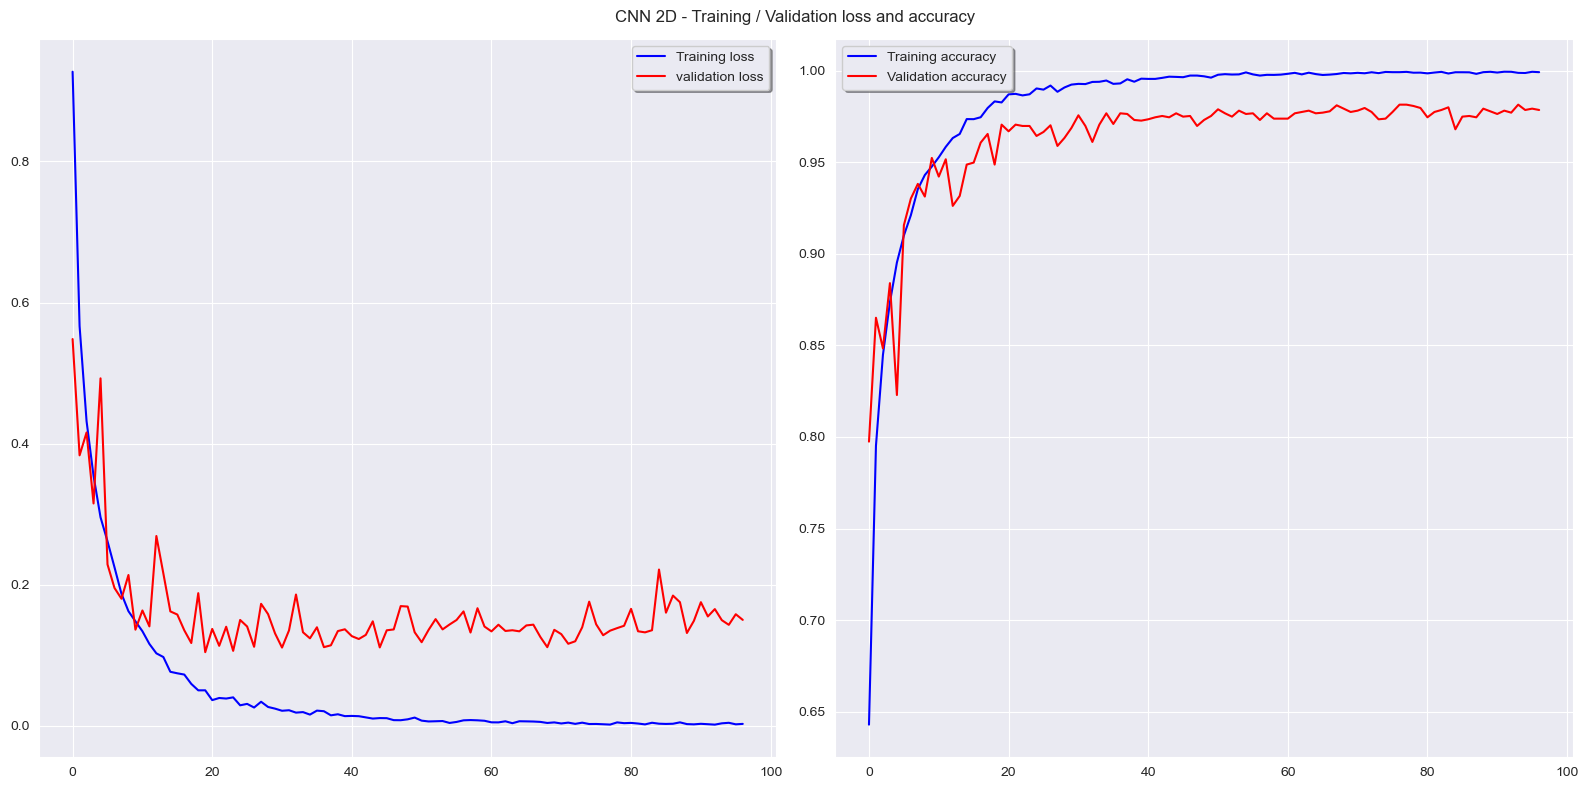

In [105]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

fig, ax = plt.subplots(1,2, figsize=(16,8))
fig.suptitle('CNN 2D - Training / Validation loss and accuracy')
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)
fig.tight_layout()
plt.savefig(os.path.join(path_pic, picture_name))

In [106]:
# save model and architecture to single file (not the best model though)

# Model_CNN_2D.save(path_models + "Model_CNN_2D.h5")
# print("Saved model to disk")

In [107]:
y_pred_CNN_2d = np.argmax(Model_CNN_2D.predict(X_val),axis=1)
y_pred_CNN_2d

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [108]:
y_test_enc = np.argmax(y_OHEV_val, axis=1)
y_test_enc

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [109]:
score_CNN_2D[1]

0.829900324344635

In [110]:
metrics_set_CNN_2D = classification_report(y_test_enc, y_pred_CNN_2d, target_names=nom_classes)
print(metrics_set_CNN_2D)

                  precision    recall  f1-score   support

      background       0.79      0.80      0.79       756
        car_horn       0.95      0.82      0.88       252
children_playing       0.75      0.87      0.81       700
        dog_bark       0.85      0.85      0.85       700
           siren       0.93      0.81      0.87       602

        accuracy                           0.83      3010
       macro avg       0.86      0.83      0.84      3010
    weighted avg       0.84      0.83      0.83      3010



In [111]:
# Load the model with the highest accuracy
# This model will be used in the notebook 10_ESR_data_preparation.ipynb

# Architecture based on Luz et al. (2021)

Model_CNN_2D_saved = load_model(os.path.join(path_models, 'Model_CNN_2D_weights_0_best' + model_surname + '.hdf5'))
Model_CNN_2D_saved.summary()

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 180, 44, 24)       624       
_________________________________________________________________
batch_normalization_4 (Batch (None, 180, 44, 24)       96        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 22, 24)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 22, 48)        28848     
_________________________________________________________________
batch_normalization_5 (Batch (None, 90, 22, 48)        192       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 11, 48)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 45, 11, 48)   

In [112]:
score_CNN_2D_saved = Model_CNN_2D_saved.evaluate(X_val, y_OHEV_val, verbose=1, batch_size = batch_size)
print('Test loss:', score_CNN_2D_saved[0])
print('Test accuracy:', score_CNN_2D_saved[1])

95/95 [==============================] - 4s 41ms/step - loss: 1.6384 - accuracy: 0.8299
Test loss: 1.6384164094924927
Test accuracy: 0.829900324344635


In [113]:
y_pred_CNN_2D_saved = np.argmax(Model_CNN_2D_saved.predict(X_val),axis=1)
y_pred_CNN_2D_saved

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

In [114]:
prob = np.round(Model_CNN_2D_saved.predict(X_val)[7],6)
for i in prob:
    print(i)

0.0
0.0
0.0
1.0
0.0


In [115]:
metrics_set_CNN_2D_saved = classification_report(y_test_enc, y_pred_CNN_2D_saved, target_names=nom_classes)
print(metrics_set_CNN_2D_saved)

                  precision    recall  f1-score   support

      background       0.79      0.80      0.79       756
        car_horn       0.95      0.82      0.88       252
children_playing       0.75      0.87      0.81       700
        dog_bark       0.85      0.85      0.85       700
           siren       0.93      0.81      0.87       602

        accuracy                           0.83      3010
       macro avg       0.86      0.83      0.84      3010
    weighted avg       0.84      0.83      0.83      3010



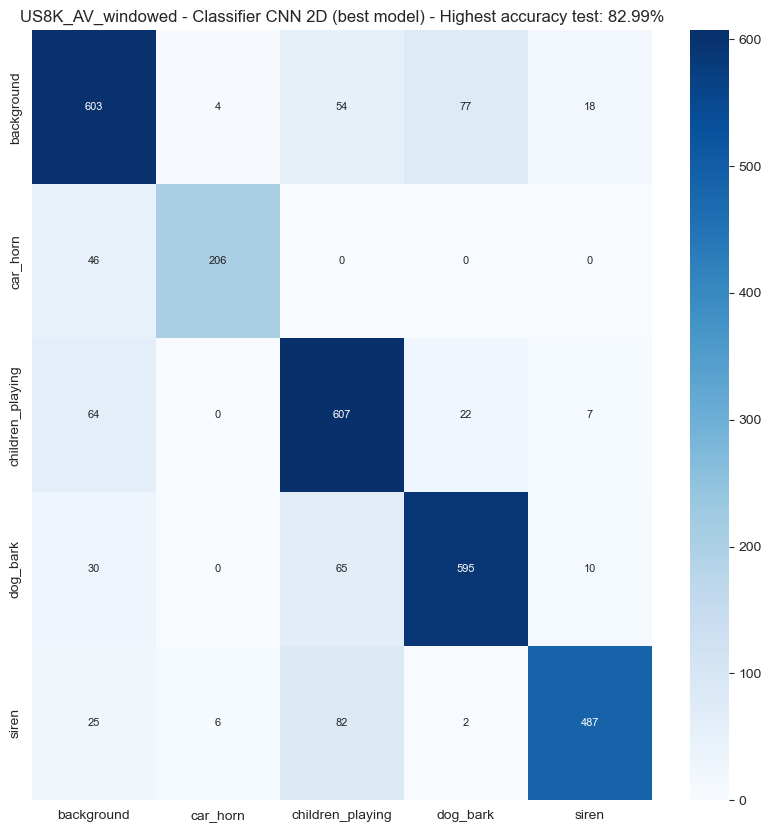

In [116]:
# Simple confusion matrix
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

conf_matrix = metrics.confusion_matrix(y_test_enc, y_pred_CNN_2D_saved)
title = nom_dataset + model_surname + ' - Classifier CNN 2D (best model) - Highest accuracy test: '+ str("{:0.2f}%".format(score_CNN_2D_saved[1]*100))

plt.figure(figsize = (10,10))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='g', 
            cmap=cmap_cm, 
            annot_kws={"size": 8}, 
            xticklabels=nom_classes, 
            yticklabels=nom_classes)
plt.title(title, fontsize = 12)
plt.savefig(os.path.join(path_pic, picture_name))
plt.show()

In [117]:
Model_CNN_2D_saved.layers

In [118]:
for layer in Model_CNN_2D_saved.layers:
    print(layer.get_weights())

[array([[[[-8.94407928e-02,  4.85165864e-02,  9.37449653e-03,
           2.59830821e-02, -1.69833362e-01, -7.90265724e-02,
           3.54951073e-04,  1.68912753e-01, -1.58002786e-02,
          -5.21692149e-02,  1.79596767e-01,  3.96305732e-02,
           7.06855506e-02, -1.02945920e-02, -5.58533110e-02,
          -3.11651945e-01,  2.74355430e-02,  7.35694766e-02,
           8.32746923e-02, -1.65471900e-02,  9.78809670e-02,
          -8.47885665e-03, -1.34837300e-01, -7.05119744e-02]],

        [[ 3.23499814e-02, -1.14941155e-03,  8.22606534e-02,
          -3.38686854e-02, -8.02912489e-02, -5.45309186e-02,
           1.94970854e-02,  2.62895375e-01,  1.34725884e-01,
           1.08515315e-01,  2.22600251e-01,  3.86003666e-02,
           1.09981477e-01,  8.98171961e-02, -5.66624887e-02,
           2.27877516e-02,  3.28382626e-02, -9.43799620e-04,
          -4.84756660e-03,  1.03688136e-01,  1.76393673e-01,
           1.21165484e-01, -1.27021432e-01, -4.78365384e-02]],

        [[-1.1232

## Metrics for the classifiers


1. Accuracy: Accuracy is a measure of how many correct predictions a model makes overall, i.e., the ratio of correct predictions to the total number of predictions. It's a commonly used metric for evaluating models, but it may not be suitable in certain situations.

2. Precision: Precision measures the ratio of true positives (correctly predicted positive instances) to all instances predicted as positive. It focuses on the accuracy of positive predictions.

3. Recall: Recall, also known as sensitivity or true positive rate, measures the ratio of true positives to all actual positive instances. It focuses on how well a model captures all the positive instances.

4. F1 Score: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that takes into account both false positives and false negatives. The F1 score is especially useful when you want to strike a balance between precision and recall.


The F1 score is a metric that combines precision and recall, and it is particularly useful in situations where class imbalance or unequal misclassification costs are present. In such contexts, the F1 score can be more informative and meaningful than accuracy.

A context where considering the F1 score makes more sense than accuracy:

**Medical Diagnosis:**

Imagine you're developing a model to diagnose a rare disease, and only 5% of the population has this disease. In this case, you have a significant class imbalance, where the majority of cases are negative (non-disease) and only a small fraction are positive (disease). If you were to use accuracy as the evaluation metric, the model could achieve a high accuracy by simply predicting "negative" for every case, because it would be correct 95% of the time due to the class imbalance. However, this would be entirely useless for detecting the actual disease.

In this scenario, you'd be more interested in the F1 score. The F1 score considers both precision and recall, helping you find a balance between correctly identifying the disease (high recall) and not making too many false positive predictions (high precision). A high F1 score in this context indicates that your model is effective at correctly identifying the disease while minimizing false alarms.

In [47]:
classifiers = ['Model_CNN_2D_Su', 'Model_CNN_2D_Luz']

In [48]:
# Pipeline to run the classifiers and their metrics

def model_classifiers(classifiers:list, db: pd.DataFrame):
    
    # Clear the session to start a new training
    K.clear_session()
                      
    monitor = EarlyStopping(monitor='val_accuracy', 
                        min_delta = 0.0001, 
                        patience = 20, 
                        verbose = 1, 
                        mode = 'auto', 
                        restore_best_weights = True)
                      
    count       = 1
    verbose     = True
    models      = []
    acc_set     = pd.DataFrame(index=None, columns=['Model',
                                                    'Fold',
                                                    'Accuracy(Train)',
                                                    'Accuracy(Val)',
                                                    'F1(Train)',
                                                    'F1(Val)', 
                                                    'Precision(Train)',
                                                    'Precision(Val)', 
                                                    'Recall(Train)',
                                                    'Recall(Val)', 
                                                    'Conf_M',
                                                    'Process_time',                                                     
                                                    'Class_report(Val)'])
                      
    for fold in np.unique(db['Fold']):
        print(f"\nValidation fold: {fold}")

        DB_VAL = db[db['Fold'] == fold]
        DB_TRN = db[db['Fold'] != fold]

        X      = DB_TRN['features'].to_numpy()
        y      = np.array(DB_TRN.Class_categorical.to_list())
        y_OHEV = np.array(DB_TRN.Class_OHEV.to_list())

        X_val      = DB_VAL['features'].to_numpy()
        y_val      = np.array(DB_VAL.Class_categorical.to_list())
        y_OHEV_val = np.array(DB_VAL.Class_OHEV.to_list())


        # Stackup and pass all values to float32
        X = np.stack(X)
        X = np.asarray(X).astype(np.float32)

        X_val = np.stack(X_val)
        X_val = np.asarray(X_val).astype(np.float32)

        y_OHEV     = np.asarray(y_OHEV).astype(np.float32)
        y_OHEV_val = np.asarray(y_OHEV_val).astype(np.float32)

        X_train_final, X_test, y_train_final, y_test = train_test_split(X,
                                                                        y_OHEV, 
                                                                        test_size = 0.1, 
                                                                        random_state = 100, 
                                                                        stratify = y_OHEV)
        
        print("\n========================================================================")
        print("Training set\n")

        print(f'X_train.........: {np.shape(X_train_final)} ...type: {type(X_train_final[0][0][0][0])}')
        print(f'y_train_OHEV....: {np.shape(y_train_final)} ............type: {type(y_train_final[0][0])}')

        print("\n========================================================================")
        print("Testing set\n")

        print(f'X_test..........: {np.shape(X_test)} ....type: {type(X_test[0][0][0][0])}')
        print(f'y_test_OHEV.....: {np.shape(y_test)} .............type: {type(y_test[0][0])}')

        print("\n========================================================================")
        print("Validation set\n")

        print(f'X_val...........: {np.shape(X_val)} ....type: {type(X_val[0][0][0][0])}')
        print(f'y_OHEV_val......: {np.shape(y_OHEV_val)} .............type: {type(y_OHEV_val[0][0])}')
        print()

        
        for i in tqdm(range(len(classifiers))):
            
            name         = classifiers[i]
            model_name   = (classifiers[i] + '_' + str(count))
            count        = count + 1
            
            if not os.path.exists(path_models):
                os.makedirs(path_models)

            filepath       = os.path.join(path_models, classifiers[i] + '_weights_0_best' + model_surname + '.hdf5')
            checkpoint     = ModelCheckpoint(filepath, 
                                             monitor = 'val_accuracy', 
                                             verbose = 1, 
                                             save_best_only = True, 
                                             mode = 'max')
            callbacks_list = [checkpoint, monitor]

            if classifiers[i] == 'Model_CNN_2D_Su':
                model = basemodel_Su(classifiers[i])
                model.summary()
                print(model_name)
            
            elif classifiers[i] == 'Model_CNN_2D_Luz':
                model = basemodel_Luz(classifiers[i])
                model.summary()
                print(model_name)
            else:
                pass


            model.fit(X_train_final, 
                      y_train_final,
                      batch_size          = batch_size,
                      epochs              = epochs,
                      verbose             = 1,
                      validation_data     = (X_test, y_test),
                      steps_per_epoch     = int(np.ceil(X_train_final.shape[0] / float(batch_size))),
                      callbacks           = callbacks_list,
                      use_multiprocessing = True)
                      
            # Get the model predictions
            y_train_enc = np.argmax(y_train_final, axis=1)
            y_val_enc   = np.argmax(y_OHEV_val, axis=1)

            y_train_predicted = np.argmax(model.predict(X_train_final), axis=1)

            t_srt             = time.process_time_ns()
            y_val_predicted   = np.argmax(model.predict(X_val), axis=1)
            t_end             = time.process_time_ns()
            proc_time         = ((t_end - t_srt) / 1000000)   
            
            # Compute the classifier metrics
            accuracy_train = metrics.accuracy_score(y_train_enc, y_train_predicted)
            accuracy_val   = metrics.accuracy_score(y_val_enc,  y_val_predicted)

            f1_Score_train = metrics.f1_score(y_train_enc, y_train_predicted, average = 'weighted')
            f1_Score_val   = metrics.f1_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            precision_score_train = metrics.precision_score(y_train_enc, y_train_predicted, average = 'weighted')
            precision_score_val   = metrics.precision_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            recall_score_train = metrics.recall_score(y_train_enc, y_train_predicted, average = 'weighted')
            recall_score_val   = metrics.recall_score(y_val_enc,  y_val_predicted,  average = 'weighted')

            class_report_val = classification_report(y_val_enc, y_val_predicted, target_names = nom_classes)
            print(class_report_val)
            
            # Compute the confusion matrix
            CM = metrics.confusion_matrix(y_val_enc, y_val_predicted)
            y_val_enc       = []
            y_val_predicted = []

            # Store the name, test accuracy results and model
            models.append((name, accuracy_val, model))
            
            K.clear_session()
            del model
                    
            acc_set = pd.concat([acc_set, pd.DataFrame({'Model': [name],
                                                        'Fold': [fold],
                                                        'Accuracy(Train)': [accuracy_train],
                                                        'Accuracy(Val)': [accuracy_val],
                                                        'F1(Train)': [f1_Score_train],
                                                        'F1(Val)': [f1_Score_val],
                                                        'Precision(Train)': [precision_score_train],
                                                        'Precision(Val)': [precision_score_val],
                                                        'Recall(Train)': [recall_score_train],
                                                        'Recall(Val)': [recall_score_val],
                                                        'Conf_M': [CM],
                                                        'Process_time': [proc_time],
                                                        'Class_report(Val)': class_report_val})], ignore_index = True)
                   
    return acc_set, models

In [49]:
metrics_set, models_set  = model_classifiers(classifiers, DB_from_pkl)


Validation fold: 1

Training set

X_train.........: (21211, 180, 173, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (21211, 5) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (2357, 180, 173, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (2357, 5) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (2580, 180, 173, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (2580, 5) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 87, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 87, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 43, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 43, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 21, 64)    

Epoch 39/100
662/663 [============================>.] - ETA: 0s - loss: 0.0748 - accuracy: 0.9732
Epoch 00039: val_accuracy did not improve from 0.98345
663/663 [==============================] - 16s 24ms/step - loss: 0.0748 - accuracy: 0.9732 - val_loss: 0.0900 - val_accuracy: 0.9784
Epoch 40/100
662/663 [============================>.] - ETA: 0s - loss: 0.0731 - accuracy: 0.9737
Epoch 00040: val_accuracy did not improve from 0.98345
663/663 [==============================] - 16s 24ms/step - loss: 0.0732 - accuracy: 0.9736 - val_loss: 0.0754 - val_accuracy: 0.9830
Epoch 41/100
662/663 [============================>.] - ETA: 0s - loss: 0.0751 - accuracy: 0.9737
Epoch 00041: val_accuracy did not improve from 0.98345
663/663 [==============================] - 16s 24ms/step - loss: 0.0752 - accuracy: 0.9736 - val_loss: 0.0921 - val_accuracy: 0.9762
Epoch 42/100
663/663 [==============================] - ETA: 0s - loss: 0.0689 - accuracy: 0.9759
Epoch 00042: val_accuracy did not improve fr

 50%|█████████████████████████████████████████                                         | 1/2 [18:32<18:32, 1112.77s/it]

                  precision    recall  f1-score   support

      background       0.92      0.86      0.89       648
        car_horn       0.92      0.92      0.92       216
children_playing       0.77      0.91      0.83       600
        dog_bark       0.89      0.86      0.87       600
           siren       0.93      0.84      0.88       516

        accuracy                           0.87      2580
       macro avg       0.88      0.88      0.88      2580
    weighted avg       0.88      0.87      0.87      2580

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 173, 24)      624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 173, 24)      96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 86, 24)      

Epoch 41/100
663/663 [==============================] - ETA: 0s - loss: 0.0109 - accuracy: 0.9969
Epoch 00041: val_accuracy improved from 0.98685 to 0.98939, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
663/663 [==============================] - 41s 62ms/step - loss: 0.0109 - accuracy: 0.9969 - val_loss: 0.0521 - val_accuracy: 0.9894
Epoch 42/100
663/663 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9971
Epoch 00042: val_accuracy did not improve from 0.98939
663/663 [==============================] - 41s 62ms/step - loss: 0.0107 - accuracy: 0.9971 - val_loss: 0.0491 - val_accuracy: 0.9860
Epoch 43/100
663/663 [==============================] - ETA: 0s - loss: 0.0094 - accuracy: 0.9969
Epoch 00043: val_accuracy did not improve from 0.98939
663/663 [==============================] - 41s 62ms/step - loss: 0.0094 - accuracy: 0.9969 - val_loss: 0.0616 - val_accuracy: 

Epoch 96/100
663/663 [==============================] - ETA: 0s - loss: 0.0019 - accuracy: 0.9995
Epoch 00096: val_accuracy did not improve from 0.99279
663/663 [==============================] - 41s 62ms/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 0.0988 - val_accuracy: 0.9830
Epoch 97/100
663/663 [==============================] - ETA: 0s - loss: 0.0032 - accuracy: 0.9990
Epoch 00097: val_accuracy did not improve from 0.99279
663/663 [==============================] - 41s 62ms/step - loss: 0.0032 - accuracy: 0.9990 - val_loss: 0.0707 - val_accuracy: 0.9911
Epoch 98/100
663/663 [==============================] - ETA: 0s - loss: 0.0023 - accuracy: 0.9992
Epoch 00098: val_accuracy did not improve from 0.99279
663/663 [==============================] - 41s 62ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.0613 - val_accuracy: 0.9911
Epoch 99/100
663/663 [==============================] - ETA: 0s - loss: 0.0035 - accuracy: 0.9990
Epoch 00099: val_accuracy did not improve fr

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:28:47<00:00, 2663.95s/it]

                  precision    recall  f1-score   support

      background       0.89      0.86      0.87       648
        car_horn       0.99      0.85      0.91       216
children_playing       0.86      0.93      0.89       600
        dog_bark       0.89      0.95      0.92       600
           siren       0.94      0.86      0.90       516

        accuracy                           0.90      2580
       macro avg       0.91      0.89      0.90      2580
    weighted avg       0.90      0.90      0.90      2580


Validation fold: 10



Training set

X_train.........: (21270, 180, 173, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (21270, 5) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (2364, 180, 173, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (2364, 5) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (2514, 180, 173, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (2514, 5) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 87, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 87, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 43, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 43, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 21, 64)    

Epoch 16/100
664/665 [============================>.] - ETA: 0s - loss: 0.2257 - accuracy: 0.9153
Epoch 00016: val_accuracy did not improve from 0.93697
665/665 [==============================] - 15s 23ms/step - loss: 0.2256 - accuracy: 0.9154 - val_loss: 0.2120 - val_accuracy: 0.9272
Epoch 17/100
665/665 [==============================] - ETA: 0s - loss: 0.2119 - accuracy: 0.9235
Epoch 00017: val_accuracy did not improve from 0.93697
665/665 [==============================] - 15s 23ms/step - loss: 0.2119 - accuracy: 0.9235 - val_loss: 0.1901 - val_accuracy: 0.9349
Epoch 18/100
664/665 [============================>.] - ETA: 0s - loss: 0.2065 - accuracy: 0.9262
Epoch 00018: val_accuracy improved from 0.93697 to 0.95008, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
665/665 [==============================] - 15s 23ms/step - loss: 0.2065 - accuracy: 0.9261 - val_loss: 0.1416 - val_accuracy: 0

Epoch 41/100
664/665 [============================>.] - ETA: 0s - loss: 0.0851 - accuracy: 0.9704
Epoch 00041: val_accuracy did not improve from 0.98181
665/665 [==============================] - 15s 23ms/step - loss: 0.0851 - accuracy: 0.9704 - val_loss: 0.0651 - val_accuracy: 0.9788
Epoch 42/100
664/665 [============================>.] - ETA: 0s - loss: 0.0803 - accuracy: 0.9705
Epoch 00042: val_accuracy did not improve from 0.98181
665/665 [==============================] - 15s 23ms/step - loss: 0.0803 - accuracy: 0.9705 - val_loss: 0.0842 - val_accuracy: 0.9725
Epoch 43/100
663/665 [============================>.] - ETA: 0s - loss: 0.0823 - accuracy: 0.9702
Epoch 00043: val_accuracy did not improve from 0.98181
665/665 [==============================] - 15s 22ms/step - loss: 0.0821 - accuracy: 0.9702 - val_loss: 0.0564 - val_accuracy: 0.9818
Epoch 44/100
664/665 [============================>.] - ETA: 0s - loss: 0.0810 - accuracy: 0.9702
Epoch 00044: val_accuracy did not improve fr

664/665 [============================>.] - ETA: 0s - loss: 0.0291 - accuracy: 0.9898
Epoch 00095: val_accuracy did not improve from 0.99112
665/665 [==============================] - 15s 23ms/step - loss: 0.0291 - accuracy: 0.9898 - val_loss: 0.0416 - val_accuracy: 0.9865
Epoch 96/100
664/665 [============================>.] - ETA: 0s - loss: 0.0281 - accuracy: 0.9902
Epoch 00096: val_accuracy did not improve from 0.99112
665/665 [==============================] - 15s 23ms/step - loss: 0.0281 - accuracy: 0.9902 - val_loss: 0.0381 - val_accuracy: 0.9894
Epoch 97/100
664/665 [============================>.] - ETA: 0s - loss: 0.0263 - accuracy: 0.9912
Epoch 00097: val_accuracy did not improve from 0.99112
665/665 [==============================] - 15s 23ms/step - loss: 0.0263 - accuracy: 0.9913 - val_loss: 0.0378 - val_accuracy: 0.9898
Epoch 98/100
663/665 [============================>.] - ETA: 0s - loss: 0.0260 - accuracy: 0.9904
Epoch 00098: val_accuracy did not improve from 0.99112
66

 50%|█████████████████████████████████████████                                         | 1/2 [25:27<25:27, 1527.71s/it]

                  precision    recall  f1-score   support

      background       0.84      0.91      0.88       618
        car_horn       0.86      0.93      0.90       198
children_playing       0.75      0.90      0.82       600
        dog_bark       0.77      0.79      0.78       600
           siren       0.91      0.56      0.69       498

        accuracy                           0.81      2514
       macro avg       0.83      0.82      0.81      2514
    weighted avg       0.82      0.81      0.80      2514

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 173, 24)      624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 173, 24)      96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 86, 24)      

Epoch 13/100
664/665 [============================>.] - ETA: 0s - loss: 0.0655 - accuracy: 0.9779
Epoch 00013: val_accuracy improved from 0.96447 to 0.97885, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
665/665 [==============================] - 41s 62ms/step - loss: 0.0655 - accuracy: 0.9779 - val_loss: 0.0656 - val_accuracy: 0.9788
Epoch 14/100
664/665 [============================>.] - ETA: 0s - loss: 0.0589 - accuracy: 0.9804
Epoch 00014: val_accuracy did not improve from 0.97885
665/665 [==============================] - 42s 63ms/step - loss: 0.0589 - accuracy: 0.9804 - val_loss: 0.1003 - val_accuracy: 0.9691
Epoch 15/100
664/665 [============================>.] - ETA: 0s - loss: 0.0559 - accuracy: 0.9812
Epoch 00015: val_accuracy did not improve from 0.97885
665/665 [==============================] - 43s 64ms/step - loss: 0.0559 - accuracy: 0.9812 - val_loss: 0.0944 - val_accuracy: 

Epoch 40/100
664/665 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9965
Epoch 00040: val_accuracy did not improve from 0.98858
665/665 [==============================] - 41s 62ms/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 0.0744 - val_accuracy: 0.9805
Epoch 41/100
664/665 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9976
Epoch 00041: val_accuracy did not improve from 0.98858
665/665 [==============================] - 41s 62ms/step - loss: 0.0088 - accuracy: 0.9976 - val_loss: 0.0585 - val_accuracy: 0.9860
Epoch 42/100
664/665 [============================>.] - ETA: 0s - loss: 0.0118 - accuracy: 0.9963
Epoch 00042: val_accuracy improved from 0.98858 to 0.98900, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
665/665 [==============================] - 41s 62ms/step - loss: 0.0118 - accuracy: 0.9963 - val_loss: 0.0482 - val_accuracy: 

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:19:26<00:00, 2383.31s/it]

                  precision    recall  f1-score   support

      background       0.89      0.88      0.88       618
        car_horn       0.84      0.95      0.89       198
children_playing       0.90      0.91      0.90       600
        dog_bark       0.74      0.89      0.81       600
           siren       0.91      0.63      0.75       498

        accuracy                           0.85      2514
       macro avg       0.85      0.85      0.85      2514
    weighted avg       0.85      0.85      0.84      2514


Validation fold: 2



Training set

X_train.........: (21216, 180, 173, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (21216, 5) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (2358, 180, 173, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (2358, 5) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (2574, 180, 173, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (2574, 5) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 87, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 87, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 43, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 43, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 21, 64)    

Epoch 15/100
661/663 [============================>.] - ETA: 0s - loss: 0.2191 - accuracy: 0.9221
Epoch 00015: val_accuracy improved from 0.93299 to 0.95759, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
663/663 [==============================] - 15s 22ms/step - loss: 0.2195 - accuracy: 0.9220 - val_loss: 0.1287 - val_accuracy: 0.9576
Epoch 16/100
661/663 [============================>.] - ETA: 0s - loss: 0.2042 - accuracy: 0.9248
Epoch 00016: val_accuracy did not improve from 0.95759
663/663 [==============================] - 15s 22ms/step - loss: 0.2040 - accuracy: 0.9249 - val_loss: 0.1999 - val_accuracy: 0.9288
Epoch 17/100
661/663 [============================>.] - ETA: 0s - loss: 0.1993 - accuracy: 0.9258
Epoch 00017: val_accuracy did not improve from 0.95759
663/663 [==============================] - 15s 22ms/step - loss: 0.1988 - accuracy: 0.9260 - val_loss: 0.1394 - val_accuracy: 0

Epoch 40/100
661/663 [============================>.] - ETA: 0s - loss: 0.0778 - accuracy: 0.9726
Epoch 00040: val_accuracy did not improve from 0.98176
663/663 [==============================] - 15s 22ms/step - loss: 0.0778 - accuracy: 0.9726 - val_loss: 0.0791 - val_accuracy: 0.9716
Epoch 41/100
661/663 [============================>.] - ETA: 0s - loss: 0.0787 - accuracy: 0.9729
Epoch 00041: val_accuracy improved from 0.98176 to 0.98388, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
663/663 [==============================] - 15s 22ms/step - loss: 0.0788 - accuracy: 0.9729 - val_loss: 0.0587 - val_accuracy: 0.9839
Epoch 42/100
661/663 [============================>.] - ETA: 0s - loss: 0.0742 - accuracy: 0.9732
Epoch 00042: val_accuracy improved from 0.98388 to 0.98728, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0

Epoch 67/100
663/663 [==============================] - ETA: 0s - loss: 0.0413 - accuracy: 0.9859
Epoch 00067: val_accuracy did not improve from 0.99109
663/663 [==============================] - 15s 22ms/step - loss: 0.0413 - accuracy: 0.9859 - val_loss: 0.0658 - val_accuracy: 0.9754
Epoch 68/100
661/663 [============================>.] - ETA: 0s - loss: 0.0378 - accuracy: 0.9871
Epoch 00068: val_accuracy did not improve from 0.99109
663/663 [==============================] - 14s 22ms/step - loss: 0.0379 - accuracy: 0.9870 - val_loss: 0.0411 - val_accuracy: 0.9860
Epoch 69/100
661/663 [============================>.] - ETA: 0s - loss: 0.0349 - accuracy: 0.9880
Epoch 00069: val_accuracy did not improve from 0.99109
663/663 [==============================] - 14s 22ms/step - loss: 0.0349 - accuracy: 0.9880 - val_loss: 0.0388 - val_accuracy: 0.9885
Epoch 70/100
661/663 [============================>.] - ETA: 0s - loss: 0.0367 - accuracy: 0.9876
Epoch 00070: val_accuracy did not improve fr

 50%|█████████████████████████████████████████                                         | 1/2 [24:23<24:23, 1463.87s/it]

                  precision    recall  f1-score   support

      background       0.78      0.92      0.84       576
        car_horn       0.93      0.80      0.86       252
children_playing       0.87      0.89      0.88       600
        dog_bark       0.91      0.91      0.91       600
           siren       0.96      0.79      0.87       546

        accuracy                           0.87      2574
       macro avg       0.89      0.86      0.87      2574
    weighted avg       0.88      0.87      0.87      2574

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 173, 24)      624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 173, 24)      96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 86, 24)      

Epoch 15/100
663/663 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9815
Epoch 00015: val_accuracy did not improve from 0.97583
663/663 [==============================] - 41s 62ms/step - loss: 0.0544 - accuracy: 0.9815 - val_loss: 0.0832 - val_accuracy: 0.9737
Epoch 16/100
663/663 [==============================] - ETA: 0s - loss: 0.0549 - accuracy: 0.9825
Epoch 00016: val_accuracy did not improve from 0.97583
663/663 [==============================] - 41s 62ms/step - loss: 0.0549 - accuracy: 0.9825 - val_loss: 0.0980 - val_accuracy: 0.9699
Epoch 17/100
663/663 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9833
Epoch 00017: val_accuracy did not improve from 0.97583
663/663 [==============================] - 41s 62ms/step - loss: 0.0496 - accuracy: 0.9833 - val_loss: 0.1420 - val_accuracy: 0.9589
Epoch 18/100
663/663 [==============================] - ETA: 0s - loss: 0.0515 - accuracy: 0.9835
Epoch 00018: val_accuracy improved from 0.97

Epoch 41/100
663/663 [==============================] - ETA: 0s - loss: 0.0114 - accuracy: 0.9966
Epoch 00041: val_accuracy improved from 0.98601 to 0.98855, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
663/663 [==============================] - 41s 62ms/step - loss: 0.0114 - accuracy: 0.9966 - val_loss: 0.0497 - val_accuracy: 0.9885
Epoch 42/100
663/663 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 0.9971
Epoch 00042: val_accuracy improved from 0.98855 to 0.98897, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
663/663 [==============================] - 41s 62ms/step - loss: 0.0096 - accuracy: 0.9971 - val_loss: 0.0536 - val_accuracy: 0.9890
Epoch 43/100
663/663 [==============================] - ETA: 0s - loss: 0.0148 - accuracy: 0.9953
Epoch 00043: val_accuracy did no

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:24:38<00:00, 2539.49s/it]

                  precision    recall  f1-score   support

      background       0.91      0.88      0.89       576
        car_horn       0.84      0.78      0.81       252
children_playing       0.83      0.95      0.89       600
        dog_bark       0.93      0.95      0.94       600
           siren       1.00      0.89      0.94       546

        accuracy                           0.90      2574
       macro avg       0.90      0.89      0.89      2574
    weighted avg       0.91      0.90      0.90      2574


Validation fold: 3



Training set

X_train.........: (20930, 180, 173, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (20930, 5) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (2326, 180, 173, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (2326, 5) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (2892, 180, 173, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (2892, 5) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 87, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 87, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 43, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 43, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 21, 64)    

Epoch 17/100
652/655 [============================>.] - ETA: 0s - loss: 0.1919 - accuracy: 0.9301
Epoch 00017: val_accuracy did not improve from 0.95099
655/655 [==============================] - 15s 22ms/step - loss: 0.1918 - accuracy: 0.9302 - val_loss: 0.1572 - val_accuracy: 0.9411
Epoch 18/100
652/655 [============================>.] - ETA: 0s - loss: 0.1840 - accuracy: 0.9336
Epoch 00018: val_accuracy improved from 0.95099 to 0.96733, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
655/655 [==============================] - 15s 22ms/step - loss: 0.1839 - accuracy: 0.9335 - val_loss: 0.0976 - val_accuracy: 0.9673
Epoch 19/100
655/655 [==============================] - ETA: 0s - loss: 0.1681 - accuracy: 0.9379
Epoch 00019: val_accuracy did not improve from 0.96733
655/655 [==============================] - 15s 22ms/step - loss: 0.1681 - accuracy: 0.9379 - val_loss: 0.1472 - val_accuracy: 0

Epoch 41/100
655/655 [==============================] - ETA: 0s - loss: 0.0735 - accuracy: 0.9750
Epoch 00041: val_accuracy did not improve from 0.98495
655/655 [==============================] - 14s 22ms/step - loss: 0.0735 - accuracy: 0.9750 - val_loss: 0.2209 - val_accuracy: 0.9338
Epoch 42/100
655/655 [==============================] - ETA: 0s - loss: 0.0923 - accuracy: 0.9684
Epoch 00042: val_accuracy improved from 0.98495 to 0.98538, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
655/655 [==============================] - 15s 22ms/step - loss: 0.0923 - accuracy: 0.9684 - val_loss: 0.0406 - val_accuracy: 0.9854
Epoch 43/100
655/655 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9737
Epoch 00043: val_accuracy improved from 0.98538 to 0.98624, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0

655/655 [==============================] - ETA: 0s - loss: 0.0248 - accuracy: 0.9917
Epoch 00094: val_accuracy did not improve from 0.99484
655/655 [==============================] - 15s 22ms/step - loss: 0.0248 - accuracy: 0.9917 - val_loss: 0.0241 - val_accuracy: 0.9914
Epoch 95/100
655/655 [==============================] - ETA: 0s - loss: 0.0250 - accuracy: 0.9913
Epoch 00095: val_accuracy did not improve from 0.99484
655/655 [==============================] - 15s 22ms/step - loss: 0.0250 - accuracy: 0.9913 - val_loss: 0.0244 - val_accuracy: 0.9944
Epoch 96/100
652/655 [============================>.] - ETA: 0s - loss: 0.0255 - accuracy: 0.9914
Epoch 00096: val_accuracy did not improve from 0.99484
655/655 [==============================] - 15s 22ms/step - loss: 0.0256 - accuracy: 0.9913 - val_loss: 0.0192 - val_accuracy: 0.9948
Epoch 97/100
655/655 [==============================] - ETA: 0s - loss: 0.0281 - accuracy: 0.9909
Epoch 00097: val_accuracy improved from 0.99484 to 0.9952

 50%|█████████████████████████████████████████                                         | 1/2 [24:25<24:25, 1465.80s/it]

                  precision    recall  f1-score   support

      background       0.77      0.85      0.81       720
        car_horn       0.76      1.00      0.86       258
children_playing       0.89      0.89      0.89       600
        dog_bark       0.90      0.83      0.86       600
           siren       0.95      0.81      0.87       714

        accuracy                           0.86      2892
       macro avg       0.85      0.87      0.86      2892
    weighted avg       0.86      0.86      0.86      2892

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 173, 24)      624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 173, 24)      96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 86, 24)      

Epoch 14/100
654/655 [============================>.] - ETA: 0s - loss: 0.0567 - accuracy: 0.9812
Epoch 00014: val_accuracy did not improve from 0.96389
655/655 [==============================] - 41s 62ms/step - loss: 0.0567 - accuracy: 0.9812 - val_loss: 0.1470 - val_accuracy: 0.9570
Epoch 15/100
654/655 [============================>.] - ETA: 0s - loss: 0.0536 - accuracy: 0.9818
Epoch 00015: val_accuracy did not improve from 0.96389
655/655 [==============================] - 41s 62ms/step - loss: 0.0536 - accuracy: 0.9818 - val_loss: 0.2255 - val_accuracy: 0.9372
Epoch 16/100
654/655 [============================>.] - ETA: 0s - loss: 0.1012 - accuracy: 0.9682
Epoch 00016: val_accuracy improved from 0.96389 to 0.97206, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
655/655 [==============================] - 41s 62ms/step - loss: 0.1012 - accuracy: 0.9682 - val_loss: 0.0878 - val_accuracy: 

Epoch 38/100
654/655 [============================>.] - ETA: 0s - loss: 0.0109 - accuracy: 0.9964
Epoch 00038: val_accuracy did not improve from 0.99140
655/655 [==============================] - 41s 62ms/step - loss: 0.0111 - accuracy: 0.9964 - val_loss: 0.1030 - val_accuracy: 0.9772
Epoch 39/100
654/655 [============================>.] - ETA: 0s - loss: 0.0266 - accuracy: 0.9920
Epoch 00039: val_accuracy did not improve from 0.99140
655/655 [==============================] - 41s 62ms/step - loss: 0.0266 - accuracy: 0.9920 - val_loss: 0.0863 - val_accuracy: 0.9824
Epoch 40/100
654/655 [============================>.] - ETA: 0s - loss: 0.0158 - accuracy: 0.9952
Epoch 00040: val_accuracy did not improve from 0.99140
655/655 [==============================] - 41s 62ms/step - loss: 0.0158 - accuracy: 0.9952 - val_loss: 0.0642 - val_accuracy: 0.9858
Epoch 41/100
654/655 [============================>.] - ETA: 0s - loss: 0.0108 - accuracy: 0.9968
Epoch 00041: val_accuracy did not improve fr

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:27:00<00:00, 2610.46s/it]

                  precision    recall  f1-score   support

      background       0.80      0.91      0.85       720
        car_horn       0.93      0.98      0.95       258
children_playing       0.91      0.84      0.87       600
        dog_bark       0.89      0.92      0.90       600
           siren       0.98      0.87      0.92       714

        accuracy                           0.89      2892
       macro avg       0.90      0.90      0.90      2892
    weighted avg       0.90      0.89      0.89      2892


Validation fold: 4



Training set

X_train.........: (20622, 180, 173, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (20622, 5) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (2292, 180, 173, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (2292, 5) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (3234, 180, 173, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (3234, 5) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 87, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 87, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 43, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 43, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 21, 64)    

Epoch 17/100
643/645 [============================>.] - ETA: 0s - loss: 0.2010 - accuracy: 0.9268
Epoch 00017: val_accuracy did not improve from 0.94241
645/645 [==============================] - 14s 22ms/step - loss: 0.2010 - accuracy: 0.9268 - val_loss: 0.1592 - val_accuracy: 0.9415
Epoch 18/100
643/645 [============================>.] - ETA: 0s - loss: 0.1930 - accuracy: 0.9309
Epoch 00018: val_accuracy improved from 0.94241 to 0.95070, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
645/645 [==============================] - 15s 23ms/step - loss: 0.1930 - accuracy: 0.9310 - val_loss: 0.1357 - val_accuracy: 0.9507
Epoch 19/100
643/645 [============================>.] - ETA: 0s - loss: 0.1813 - accuracy: 0.9341
Epoch 00019: val_accuracy did not improve from 0.95070
645/645 [==============================] - 14s 22ms/step - loss: 0.1813 - accuracy: 0.9341 - val_loss: 0.1621 - val_accuracy: 0

643/645 [============================>.] - ETA: 0s - loss: 0.0707 - accuracy: 0.9746
Epoch 00042: val_accuracy did not improve from 0.98473
645/645 [==============================] - 14s 22ms/step - loss: 0.0706 - accuracy: 0.9746 - val_loss: 0.1027 - val_accuracy: 0.9673
Epoch 43/100
643/645 [============================>.] - ETA: 0s - loss: 0.0691 - accuracy: 0.9750
Epoch 00043: val_accuracy did not improve from 0.98473
645/645 [==============================] - 14s 22ms/step - loss: 0.0691 - accuracy: 0.9750 - val_loss: 0.0701 - val_accuracy: 0.9786
Epoch 44/100
643/645 [============================>.] - ETA: 0s - loss: 0.0720 - accuracy: 0.9747
Epoch 00044: val_accuracy did not improve from 0.98473
645/645 [==============================] - 14s 22ms/step - loss: 0.0719 - accuracy: 0.9747 - val_loss: 0.0621 - val_accuracy: 0.9812
Epoch 45/100
643/645 [============================>.] - ETA: 0s - loss: 0.0682 - accuracy: 0.9768
Epoch 00045: val_accuracy did not improve from 0.98473
64

 50%|█████████████████████████████████████████                                         | 1/2 [20:23<20:23, 1223.53s/it]

                  precision    recall  f1-score   support

      background       0.72      0.86      0.78       684
        car_horn       0.93      0.69      0.80       354
children_playing       0.73      0.76      0.74       600
        dog_bark       0.87      0.88      0.87       600
           siren       0.94      0.87      0.91       996

        accuracy                           0.83      3234
       macro avg       0.84      0.81      0.82      3234
    weighted avg       0.84      0.83      0.83      3234

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 173, 24)      624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 173, 24)      96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 86, 24)      

Epoch 14/100
644/645 [============================>.] - ETA: 0s - loss: 0.0613 - accuracy: 0.9795
Epoch 00014: val_accuracy improved from 0.96117 to 0.96466, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
645/645 [==============================] - 40s 62ms/step - loss: 0.0613 - accuracy: 0.9795 - val_loss: 0.1246 - val_accuracy: 0.9647
Epoch 15/100
644/645 [============================>.] - ETA: 0s - loss: 0.0551 - accuracy: 0.9816
Epoch 00015: val_accuracy did not improve from 0.96466
645/645 [==============================] - 40s 62ms/step - loss: 0.0551 - accuracy: 0.9816 - val_loss: 0.1684 - val_accuracy: 0.9520
Epoch 16/100
644/645 [============================>.] - ETA: 0s - loss: 0.0490 - accuracy: 0.9830
Epoch 00016: val_accuracy improved from 0.96466 to 0.97688, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights

Epoch 40/100
644/645 [============================>.] - ETA: 0s - loss: 0.0071 - accuracy: 0.9978
Epoch 00040: val_accuracy improved from 0.98997 to 0.99127, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
645/645 [==============================] - 40s 62ms/step - loss: 0.0071 - accuracy: 0.9978 - val_loss: 0.0411 - val_accuracy: 0.9913
Epoch 41/100
644/645 [============================>.] - ETA: 0s - loss: 0.0098 - accuracy: 0.9972
Epoch 00041: val_accuracy improved from 0.99127 to 0.99171, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
645/645 [==============================] - 40s 62ms/step - loss: 0.0098 - accuracy: 0.9972 - val_loss: 0.0346 - val_accuracy: 0.9917
Epoch 42/100
644/645 [============================>.] - ETA: 0s - loss: 0.0059 - accuracy: 0.9981
Epoch 00042: val_accuracy did no

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:01:30<00:00, 1845.17s/it]

                  precision    recall  f1-score   support

      background       0.72      0.88      0.79       684
        car_horn       0.97      0.65      0.78       354
children_playing       0.81      0.79      0.80       600
        dog_bark       0.87      0.89      0.88       600
           siren       0.95      0.92      0.93       996

        accuracy                           0.85      3234
       macro avg       0.86      0.83      0.84      3234
    weighted avg       0.86      0.85      0.85      3234


Validation fold: 5



Training set

X_train.........: (21006, 180, 173, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (21006, 5) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (2334, 180, 173, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (2334, 5) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (2808, 180, 173, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (2808, 5) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 87, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 87, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 43, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 43, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 21, 64)    

Epoch 16/100
655/657 [============================>.] - ETA: 0s - loss: 0.2092 - accuracy: 0.9231
Epoch 00016: val_accuracy improved from 0.93016 to 0.93488, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
657/657 [==============================] - 15s 23ms/step - loss: 0.2094 - accuracy: 0.9229 - val_loss: 0.1776 - val_accuracy: 0.9349
Epoch 17/100
655/657 [============================>.] - ETA: 0s - loss: 0.1982 - accuracy: 0.9265
Epoch 00017: val_accuracy improved from 0.93488 to 0.94944, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
657/657 [==============================] - 15s 23ms/step - loss: 0.1987 - accuracy: 0.9264 - val_loss: 0.1575 - val_accuracy: 0.9494
Epoch 18/100
655/657 [============================>.] - ETA: 0s - loss: 0.1859 - accuracy: 0.9303
Epoch 00018: val_accuracy did not 

Epoch 41/100
655/657 [============================>.] - ETA: 0s - loss: 0.0755 - accuracy: 0.9732
Epoch 00041: val_accuracy did not improve from 0.98415
657/657 [==============================] - 15s 22ms/step - loss: 0.0753 - accuracy: 0.9733 - val_loss: 0.0552 - val_accuracy: 0.9803
Epoch 42/100
655/657 [============================>.] - ETA: 0s - loss: 0.0686 - accuracy: 0.9743
Epoch 00042: val_accuracy did not improve from 0.98415
657/657 [==============================] - 15s 22ms/step - loss: 0.0686 - accuracy: 0.9742 - val_loss: 0.0614 - val_accuracy: 0.9824
Epoch 43/100
655/657 [============================>.] - ETA: 0s - loss: 0.0722 - accuracy: 0.9742
Epoch 00043: val_accuracy did not improve from 0.98415
657/657 [==============================] - 15s 22ms/step - loss: 0.0722 - accuracy: 0.9742 - val_loss: 0.0600 - val_accuracy: 0.9833
Epoch 44/100
655/657 [============================>.] - ETA: 0s - loss: 0.0651 - accuracy: 0.9768
Epoch 00044: val_accuracy did not improve fr

Epoch 95/100
655/657 [============================>.] - ETA: 0s - loss: 0.0307 - accuracy: 0.9895
Epoch 00095: val_accuracy did not improve from 0.99314
657/657 [==============================] - 15s 22ms/step - loss: 0.0306 - accuracy: 0.9895 - val_loss: 0.0345 - val_accuracy: 0.9910
Epoch 96/100
655/657 [============================>.] - ETA: 0s - loss: 0.0248 - accuracy: 0.9913
Epoch 00096: val_accuracy did not improve from 0.99314
657/657 [==============================] - 15s 22ms/step - loss: 0.0249 - accuracy: 0.9912 - val_loss: 0.0290 - val_accuracy: 0.9914
Epoch 97/100
655/657 [============================>.] - ETA: 0s - loss: 0.0237 - accuracy: 0.9917
Epoch 00097: val_accuracy improved from 0.99314 to 0.99357, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
657/657 [==============================] - 15s 23ms/step - loss: 0.0237 - accuracy: 0.9917 - val_loss: 0.0249 - val_accuracy: 0

 50%|█████████████████████████████████████████                                         | 1/2 [24:42<24:42, 1482.81s/it]

                  precision    recall  f1-score   support

      background       0.74      0.94      0.83       594
        car_horn       0.97      0.88      0.92       588
children_playing       0.84      0.83      0.84       600
        dog_bark       0.89      0.81      0.85       600
           siren       0.98      0.85      0.91       426

        accuracy                           0.86      2808
       macro avg       0.88      0.86      0.87      2808
    weighted avg       0.88      0.86      0.87      2808

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 173, 24)      624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 173, 24)      96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 86, 24)      

Epoch 15/100
656/657 [============================>.] - ETA: 0s - loss: 0.0614 - accuracy: 0.9789
Epoch 00015: val_accuracy improved from 0.96872 to 0.97301, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
657/657 [==============================] - 41s 62ms/step - loss: 0.0617 - accuracy: 0.9789 - val_loss: 0.0855 - val_accuracy: 0.9730
Epoch 16/100
656/657 [============================>.] - ETA: 0s - loss: 0.0533 - accuracy: 0.9816
Epoch 00016: val_accuracy improved from 0.97301 to 0.97515, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
657/657 [==============================] - 41s 62ms/step - loss: 0.0533 - accuracy: 0.9816 - val_loss: 0.0671 - val_accuracy: 0.9751
Epoch 17/100
656/657 [============================>.] - ETA: 0s - loss: 0.0459 - accuracy: 0.9838
Epoch 00017: val_accuracy did no

Epoch 41/100
656/657 [============================>.] - ETA: 0s - loss: 0.0164 - accuracy: 0.9951
Epoch 00041: val_accuracy did not improve from 0.98972
657/657 [==============================] - 41s 62ms/step - loss: 0.0165 - accuracy: 0.9950 - val_loss: 0.0813 - val_accuracy: 0.9816
Epoch 42/100
656/657 [============================>.] - ETA: 0s - loss: 0.0089 - accuracy: 0.9972
Epoch 00042: val_accuracy did not improve from 0.98972
657/657 [==============================] - 41s 62ms/step - loss: 0.0089 - accuracy: 0.9972 - val_loss: 0.0506 - val_accuracy: 0.9884
Epoch 43/100
656/657 [============================>.] - ETA: 0s - loss: 0.0095 - accuracy: 0.9974
Epoch 00043: val_accuracy did not improve from 0.98972
657/657 [==============================] - 41s 62ms/step - loss: 0.0095 - accuracy: 0.9974 - val_loss: 0.0549 - val_accuracy: 0.9889
Epoch 44/100
656/657 [============================>.] - ETA: 0s - loss: 0.0094 - accuracy: 0.9970
Epoch 00044: val_accuracy did not improve fr

Epoch 69/100
656/657 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9989
Epoch 00069: val_accuracy improved from 0.99186 to 0.99314, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
657/657 [==============================] - 41s 62ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0384 - val_accuracy: 0.9931
Epoch 70/100
656/657 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9990
Epoch 00070: val_accuracy did not improve from 0.99314
657/657 [==============================] - 41s 62ms/step - loss: 0.0026 - accuracy: 0.9990 - val_loss: 0.0405 - val_accuracy: 0.9927
Epoch 71/100
656/657 [============================>.] - ETA: 0s - loss: 0.0026 - accuracy: 0.9991
Epoch 00071: val_accuracy did not improve from 0.99314
657/657 [==============================] - 41s 62ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0451 - val_accuracy: 

Epoch 97/100
656/657 [============================>.] - ETA: 0s - loss: 0.0029 - accuracy: 0.9990
Epoch 00097: val_accuracy did not improve from 0.99357
657/657 [==============================] - 41s 62ms/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.0572 - val_accuracy: 0.9876
Epoch 98/100
656/657 [============================>.] - ETA: 0s - loss: 0.0035 - accuracy: 0.9989
Epoch 00098: val_accuracy did not improve from 0.99357
Restoring model weights from the end of the best epoch.
657/657 [==============================] - 41s 62ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 0.0683 - val_accuracy: 0.9893
Epoch 00098: early stopping


100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:31:50<00:00, 2755.28s/it]

                  precision    recall  f1-score   support

      background       0.72      0.92      0.81       594
        car_horn       0.97      0.89      0.93       588
children_playing       0.89      0.78      0.83       600
        dog_bark       0.88      0.87      0.87       600
           siren       0.97      0.90      0.93       426

        accuracy                           0.87      2808
       macro avg       0.89      0.87      0.87      2808
    weighted avg       0.88      0.87      0.87      2808


Validation fold: 6



Training set

X_train.........: (21373, 180, 173, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (21373, 5) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (2375, 180, 173, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (2375, 5) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (2400, 180, 173, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (2400, 5) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 87, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 87, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 43, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 43, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 21, 64)    

Epoch 17/100
667/668 [============================>.] - ETA: 0s - loss: 0.2052 - accuracy: 0.9261
Epoch 00017: val_accuracy improved from 0.93895 to 0.94147, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
668/668 [==============================] - 15s 23ms/step - loss: 0.2055 - accuracy: 0.9261 - val_loss: 0.1930 - val_accuracy: 0.9415
Epoch 18/100
667/668 [============================>.] - ETA: 0s - loss: 0.1911 - accuracy: 0.9307
Epoch 00018: val_accuracy did not improve from 0.94147
668/668 [==============================] - 15s 22ms/step - loss: 0.1911 - accuracy: 0.9306 - val_loss: 0.2066 - val_accuracy: 0.9284
Epoch 19/100
667/668 [============================>.] - ETA: 0s - loss: 0.1766 - accuracy: 0.9324
Epoch 00019: val_accuracy improved from 0.94147 to 0.95284, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0

Epoch 42/100
667/668 [============================>.] - ETA: 0s - loss: 0.0693 - accuracy: 0.9746
Epoch 00042: val_accuracy did not improve from 0.98105
668/668 [==============================] - 15s 22ms/step - loss: 0.0693 - accuracy: 0.9745 - val_loss: 0.0815 - val_accuracy: 0.9773
Epoch 43/100
667/668 [============================>.] - ETA: 0s - loss: 0.0710 - accuracy: 0.9733
Epoch 00043: val_accuracy did not improve from 0.98105
668/668 [==============================] - 15s 22ms/step - loss: 0.0711 - accuracy: 0.9733 - val_loss: 0.0882 - val_accuracy: 0.9739
Epoch 44/100
667/668 [============================>.] - ETA: 0s - loss: 0.0704 - accuracy: 0.9745
Epoch 00044: val_accuracy did not improve from 0.98105
668/668 [==============================] - 15s 22ms/step - loss: 0.0703 - accuracy: 0.9745 - val_loss: 0.0962 - val_accuracy: 0.9735
Epoch 45/100
667/668 [============================>.] - ETA: 0s - loss: 0.0694 - accuracy: 0.9755
Epoch 00045: val_accuracy did not improve fr

Epoch 69/100
667/668 [============================>.] - ETA: 0s - loss: 0.0427 - accuracy: 0.9855
Epoch 00069: val_accuracy did not improve from 0.98905
668/668 [==============================] - 15s 22ms/step - loss: 0.0427 - accuracy: 0.9855 - val_loss: 0.0381 - val_accuracy: 0.9891
Epoch 70/100
667/668 [============================>.] - ETA: 0s - loss: 0.0392 - accuracy: 0.9859
Epoch 00070: val_accuracy did not improve from 0.98905
668/668 [==============================] - 15s 22ms/step - loss: 0.0391 - accuracy: 0.9860 - val_loss: 0.0859 - val_accuracy: 0.9722
Epoch 71/100
667/668 [============================>.] - ETA: 0s - loss: 0.0361 - accuracy: 0.9874
Epoch 00071: val_accuracy improved from 0.98905 to 0.98947, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
668/668 [==============================] - 15s 23ms/step - loss: 0.0360 - accuracy: 0.9874 - val_loss: 0.0400 - val_accuracy: 0

 50%|█████████████████████████████████████████                                         | 1/2 [25:09<25:09, 1509.65s/it]

                  precision    recall  f1-score   support

      background       0.80      0.78      0.79       588
        car_horn       0.76      0.88      0.81       168
children_playing       0.87      0.94      0.91       600
        dog_bark       0.92      0.92      0.92       600
           siren       0.86      0.75      0.80       444

        accuracy                           0.86      2400
       macro avg       0.84      0.85      0.85      2400
    weighted avg       0.86      0.86      0.86      2400

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 173, 24)      624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 173, 24)      96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 86, 24)      

Epoch 39/100
668/668 [==============================] - ETA: 0s - loss: 0.0115 - accuracy: 0.9962
Epoch 00039: val_accuracy did not improve from 0.98863
668/668 [==============================] - 42s 62ms/step - loss: 0.0115 - accuracy: 0.9962 - val_loss: 0.0673 - val_accuracy: 0.9823
Epoch 40/100
668/668 [==============================] - ETA: 0s - loss: 0.0123 - accuracy: 0.9955
Epoch 00040: val_accuracy did not improve from 0.98863
668/668 [==============================] - 42s 62ms/step - loss: 0.0123 - accuracy: 0.9955 - val_loss: 0.0546 - val_accuracy: 0.9865
Epoch 41/100
668/668 [==============================] - ETA: 0s - loss: 0.0107 - accuracy: 0.9966
Epoch 00041: val_accuracy did not improve from 0.98863
668/668 [==============================] - 42s 62ms/step - loss: 0.0107 - accuracy: 0.9966 - val_loss: 0.0666 - val_accuracy: 0.9819
Epoch 42/100
668/668 [==============================] - ETA: 0s - loss: 0.0092 - accuracy: 0.9969
Epoch 00042: val_accuracy did not improve fr

Epoch 67/100
668/668 [==============================] - ETA: 0s - loss: 0.0069 - accuracy: 0.9979
Epoch 00067: val_accuracy did not improve from 0.99032
668/668 [==============================] - 42s 62ms/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.0621 - val_accuracy: 0.9886
Epoch 68/100
668/668 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9983
Epoch 00068: val_accuracy did not improve from 0.99032
668/668 [==============================] - 42s 62ms/step - loss: 0.0053 - accuracy: 0.9983 - val_loss: 0.0618 - val_accuracy: 0.9895
Epoch 69/100
668/668 [==============================] - ETA: 0s - loss: 0.0052 - accuracy: 0.9984
Epoch 00069: val_accuracy did not improve from 0.99032
668/668 [==============================] - 42s 62ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.0864 - val_accuracy: 0.9861
Epoch 70/100
668/668 [==============================] - ETA: 0s - loss: 0.0051 - accuracy: 0.9987
Epoch 00070: val_accuracy did not improve fr

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:23:39<00:00, 2509.61s/it]

                  precision    recall  f1-score   support

      background       0.81      0.83      0.82       588
        car_horn       0.87      0.86      0.87       168
children_playing       0.92      0.92      0.92       600
        dog_bark       0.91      0.96      0.93       600
           siren       0.92      0.81      0.86       444

        accuracy                           0.88      2400
       macro avg       0.88      0.88      0.88      2400
    weighted avg       0.89      0.88      0.88      2400


Validation fold: 7



Training set

X_train.........: (21346, 180, 173, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (21346, 5) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (2372, 180, 173, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (2372, 5) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (2430, 180, 173, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (2430, 5) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 87, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 87, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 43, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 43, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 21, 64)    

667/668 [============================>.] - ETA: 0s - loss: 0.0740 - accuracy: 0.9738
Epoch 00040: val_accuracy did not improve from 0.98609
668/668 [==============================] - 15s 22ms/step - loss: 0.0740 - accuracy: 0.9738 - val_loss: 0.0761 - val_accuracy: 0.9777
Epoch 41/100
667/668 [============================>.] - ETA: 0s - loss: 0.0725 - accuracy: 0.9738
Epoch 00041: val_accuracy did not improve from 0.98609
668/668 [==============================] - 15s 22ms/step - loss: 0.0727 - accuracy: 0.9737 - val_loss: 0.0501 - val_accuracy: 0.9831
Epoch 42/100
667/668 [============================>.] - ETA: 0s - loss: 0.0797 - accuracy: 0.9717
Epoch 00042: val_accuracy did not improve from 0.98609
668/668 [==============================] - 15s 22ms/step - loss: 0.0797 - accuracy: 0.9717 - val_loss: 0.0785 - val_accuracy: 0.9726
Epoch 43/100
667/668 [============================>.] - ETA: 0s - loss: 0.0736 - accuracy: 0.9732
Epoch 00043: val_accuracy did not improve from 0.98609
66

 50%|█████████████████████████████████████████                                         | 1/2 [19:38<19:38, 1178.44s/it]

                  precision    recall  f1-score   support

      background       0.77      0.79      0.78       600
        car_horn       0.81      0.81      0.81       168
children_playing       0.86      0.91      0.89       600
        dog_bark       0.88      0.88      0.88       600
           siren       0.85      0.77      0.81       462

        accuracy                           0.84      2430
       macro avg       0.83      0.83      0.83      2430
    weighted avg       0.84      0.84      0.84      2430

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 173, 24)      624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 173, 24)      96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 86, 24)      

Epoch 15/100
667/668 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9795
Epoch 00015: val_accuracy improved from 0.97428 to 0.97808, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
668/668 [==============================] - 42s 62ms/step - loss: 0.0621 - accuracy: 0.9795 - val_loss: 0.0632 - val_accuracy: 0.9781
Epoch 16/100
667/668 [============================>.] - ETA: 0s - loss: 0.0599 - accuracy: 0.9792
Epoch 00016: val_accuracy did not improve from 0.97808
668/668 [==============================] - 42s 62ms/step - loss: 0.0601 - accuracy: 0.9791 - val_loss: 0.5160 - val_accuracy: 0.8697
Epoch 17/100
667/668 [============================>.] - ETA: 0s - loss: 0.0703 - accuracy: 0.9749
Epoch 00017: val_accuracy improved from 0.97808 to 0.98019, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights

Epoch 40/100
667/668 [============================>.] - ETA: 0s - loss: 0.0130 - accuracy: 0.9958
Epoch 00040: val_accuracy did not improve from 0.98988
668/668 [==============================] - 42s 62ms/step - loss: 0.0130 - accuracy: 0.9958 - val_loss: 0.0608 - val_accuracy: 0.9865
Epoch 41/100
667/668 [============================>.] - ETA: 0s - loss: 0.0166 - accuracy: 0.9942
Epoch 00041: val_accuracy did not improve from 0.98988
668/668 [==============================] - 42s 62ms/step - loss: 0.0166 - accuracy: 0.9942 - val_loss: 0.0555 - val_accuracy: 0.9844
Epoch 42/100
667/668 [============================>.] - ETA: 0s - loss: 0.0107 - accuracy: 0.9962
Epoch 00042: val_accuracy did not improve from 0.98988
668/668 [==============================] - 42s 62ms/step - loss: 0.0107 - accuracy: 0.9962 - val_loss: 0.0542 - val_accuracy: 0.9874
Epoch 43/100
667/668 [============================>.] - ETA: 0s - loss: 0.0096 - accuracy: 0.9971
Epoch 00043: val_accuracy did not improve fr

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:00:46<00:00, 1823.06s/it]

                  precision    recall  f1-score   support

      background       0.78      0.83      0.80       600
        car_horn       0.86      0.83      0.85       168
children_playing       0.90      0.91      0.91       600
        dog_bark       0.89      0.90      0.89       600
           siren       0.87      0.77      0.82       462

        accuracy                           0.86      2430
       macro avg       0.86      0.85      0.85      2430
    weighted avg       0.86      0.86      0.86      2430


Validation fold: 8



Training set

X_train.........: (21427, 180, 173, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (21427, 5) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (2381, 180, 173, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (2381, 5) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (2340, 180, 173, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (2340, 5) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 87, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 87, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 43, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 43, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 21, 64)    

Epoch 41/100
670/670 [==============================] - ETA: 0s - loss: 0.0751 - accuracy: 0.9739
Epoch 00041: val_accuracy did not improve from 0.97942
670/670 [==============================] - 15s 22ms/step - loss: 0.0751 - accuracy: 0.9739 - val_loss: 0.0927 - val_accuracy: 0.9748
Epoch 42/100
670/670 [==============================] - ETA: 0s - loss: 0.0800 - accuracy: 0.9709
Epoch 00042: val_accuracy did not improve from 0.97942
670/670 [==============================] - 15s 22ms/step - loss: 0.0800 - accuracy: 0.9709 - val_loss: 0.0615 - val_accuracy: 0.9794
Epoch 43/100
670/670 [==============================] - ETA: 0s - loss: 0.0703 - accuracy: 0.9752
Epoch 00043: val_accuracy improved from 0.97942 to 0.98026, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Su_weights_0_best_augmented.hdf5
670/670 [==============================] - 15s 23ms/step - loss: 0.0703 - accuracy: 0.9752 - val_loss: 0.0602 - val_accuracy: 0

Epoch 95/100
670/670 [==============================] - ETA: 0s - loss: 0.0280 - accuracy: 0.9917
Epoch 00095: val_accuracy did not improve from 0.99076
670/670 [==============================] - 15s 22ms/step - loss: 0.0280 - accuracy: 0.9917 - val_loss: 0.0411 - val_accuracy: 0.9891
Epoch 96/100
670/670 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9923
Epoch 00096: val_accuracy did not improve from 0.99076
670/670 [==============================] - 15s 22ms/step - loss: 0.0243 - accuracy: 0.9923 - val_loss: 0.0396 - val_accuracy: 0.9887
Epoch 97/100
670/670 [==============================] - ETA: 0s - loss: 0.0259 - accuracy: 0.9906
Epoch 00097: val_accuracy did not improve from 0.99076
670/670 [==============================] - 15s 22ms/step - loss: 0.0259 - accuracy: 0.9906 - val_loss: 0.0445 - val_accuracy: 0.9878
Epoch 98/100
669/670 [============================>.] - ETA: 0s - loss: 0.0266 - accuracy: 0.9915
Epoch 00098: val_accuracy did not improve fr

 50%|█████████████████████████████████████████                                         | 1/2 [25:10<25:10, 1510.18s/it]

                  precision    recall  f1-score   support

      background       0.51      0.88      0.65       480
        car_horn       0.86      0.87      0.86       180
children_playing       0.83      0.67      0.74       600
        dog_bark       0.98      0.81      0.88       600
           siren       0.78      0.58      0.67       480

        accuracy                           0.74      2340
       macro avg       0.79      0.76      0.76      2340
    weighted avg       0.80      0.74      0.75      2340

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 173, 24)      624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 173, 24)      96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 86, 24)      

Epoch 15/100
669/670 [============================>.] - ETA: 0s - loss: 0.0545 - accuracy: 0.9821
Epoch 00015: val_accuracy improved from 0.97396 to 0.98152, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
670/670 [==============================] - 42s 62ms/step - loss: 0.0546 - accuracy: 0.9821 - val_loss: 0.0633 - val_accuracy: 0.9815
Epoch 16/100
669/670 [============================>.] - ETA: 0s - loss: 0.0479 - accuracy: 0.9841
Epoch 00016: val_accuracy did not improve from 0.98152
670/670 [==============================] - 42s 62ms/step - loss: 0.0479 - accuracy: 0.9841 - val_loss: 0.0952 - val_accuracy: 0.9693
Epoch 17/100
669/670 [============================>.] - ETA: 0s - loss: 0.0433 - accuracy: 0.9858
Epoch 00017: val_accuracy did not improve from 0.98152
670/670 [==============================] - 42s 62ms/step - loss: 0.0433 - accuracy: 0.9858 - val_loss: 0.0953 - val_accuracy: 

669/670 [============================>.] - ETA: 0s - loss: 0.0137 - accuracy: 0.9952
Epoch 00041: val_accuracy did not improve from 0.98992
670/670 [==============================] - 42s 62ms/step - loss: 0.0137 - accuracy: 0.9952 - val_loss: 0.0721 - val_accuracy: 0.9798
Epoch 42/100
669/670 [============================>.] - ETA: 0s - loss: 0.0126 - accuracy: 0.9963
Epoch 00042: val_accuracy did not improve from 0.98992
670/670 [==============================] - 42s 62ms/step - loss: 0.0126 - accuracy: 0.9963 - val_loss: 0.0619 - val_accuracy: 0.9803
Epoch 43/100
669/670 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9970
Epoch 00043: val_accuracy did not improve from 0.98992
670/670 [==============================] - 42s 62ms/step - loss: 0.0088 - accuracy: 0.9970 - val_loss: 0.0906 - val_accuracy: 0.9773
Epoch 44/100
669/670 [============================>.] - ETA: 0s - loss: 0.0088 - accuracy: 0.9973
Epoch 00044: val_accuracy did not improve from 0.98992
67

669/670 [============================>.] - ETA: 0s - loss: 0.0018 - accuracy: 0.9993
Epoch 00096: val_accuracy did not improve from 0.99412
670/670 [==============================] - 42s 63ms/step - loss: 0.0018 - accuracy: 0.9993 - val_loss: 0.0473 - val_accuracy: 0.9916
Epoch 97/100
669/670 [============================>.] - ETA: 0s - loss: 0.0020 - accuracy: 0.9995
Epoch 00097: val_accuracy did not improve from 0.99412
670/670 [==============================] - 42s 63ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0594 - val_accuracy: 0.9929
Epoch 98/100
669/670 [============================>.] - ETA: 0s - loss: 0.0022 - accuracy: 0.9993
Epoch 00098: val_accuracy did not improve from 0.99412
670/670 [==============================] - 42s 63ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0545 - val_accuracy: 0.9908
Epoch 99/100
669/670 [============================>.] - ETA: 0s - loss: 0.0028 - accuracy: 0.9992
Epoch 00099: val_accuracy did not improve from 0.99412
67

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:36:11<00:00, 2885.61s/it]

                  precision    recall  f1-score   support

      background       0.56      0.85      0.68       480
        car_horn       0.88      0.89      0.89       180
children_playing       0.86      0.79      0.82       600
        dog_bark       0.90      0.86      0.88       600
           siren       0.78      0.51      0.61       480

        accuracy                           0.77      2340
       macro avg       0.80      0.78      0.78      2340
    weighted avg       0.80      0.77      0.77      2340


Validation fold: 9



Training set

X_train.........: (21394, 180, 173, 1) ...type: <class 'numpy.float32'>
y_train_OHEV....: (21394, 5) ............type: <class 'numpy.float32'>

Testing set

X_test..........: (2378, 180, 173, 1) ....type: <class 'numpy.float32'>
y_test_OHEV.....: (2378, 5) .............type: <class 'numpy.float32'>

Validation set

X_val...........: (2376, 180, 173, 1) ....type: <class 'numpy.float32'>
y_OHEV_val......: (2376, 5) .............type: <class 'numpy.float32'>



  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

Model: "Model_CNN_2D_Su"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 90, 87, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 90, 87, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 44, 43, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 43, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 22, 21, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 22, 21, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 21, 64)    

Epoch 39/100
667/669 [============================>.] - ETA: 0s - loss: 0.0891 - accuracy: 0.9682
Epoch 00039: val_accuracy did not improve from 0.98402
669/669 [==============================] - 15s 23ms/step - loss: 0.0892 - accuracy: 0.9681 - val_loss: 0.0660 - val_accuracy: 0.9781
Epoch 40/100
667/669 [============================>.] - ETA: 0s - loss: 0.0871 - accuracy: 0.9687
Epoch 00040: val_accuracy did not improve from 0.98402
669/669 [==============================] - 15s 23ms/step - loss: 0.0874 - accuracy: 0.9686 - val_loss: 0.0637 - val_accuracy: 0.9798
Epoch 41/100
667/669 [============================>.] - ETA: 0s - loss: 0.0828 - accuracy: 0.9701
Epoch 00041: val_accuracy did not improve from 0.98402
669/669 [==============================] - 15s 23ms/step - loss: 0.0831 - accuracy: 0.9700 - val_loss: 0.0703 - val_accuracy: 0.9769
Epoch 42/100
667/669 [============================>.] - ETA: 0s - loss: 0.0842 - accuracy: 0.9697
Epoch 00042: val_accuracy did not improve fr

Epoch 66/100
667/669 [============================>.] - ETA: 0s - loss: 0.0441 - accuracy: 0.9845
Epoch 00066: val_accuracy did not improve from 0.99117
669/669 [==============================] - 15s 22ms/step - loss: 0.0441 - accuracy: 0.9845 - val_loss: 0.0467 - val_accuracy: 0.9886
Epoch 67/100
667/669 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.9859
Epoch 00067: val_accuracy did not improve from 0.99117
669/669 [==============================] - 15s 23ms/step - loss: 0.0430 - accuracy: 0.9860 - val_loss: 0.0439 - val_accuracy: 0.9895
Epoch 68/100
668/669 [============================>.] - ETA: 0s - loss: 0.0443 - accuracy: 0.9847
Epoch 00068: val_accuracy did not improve from 0.99117
669/669 [==============================] - 15s 23ms/step - loss: 0.0443 - accuracy: 0.9847 - val_loss: 0.0416 - val_accuracy: 0.9882
Epoch 69/100
669/669 [==============================] - ETA: 0s - loss: 0.0433 - accuracy: 0.9849
Epoch 00069: val_accuracy did not improve fr

Epoch 94/100
669/669 [==============================] - ETA: 0s - loss: 0.0289 - accuracy: 0.9910
Epoch 00094: val_accuracy did not improve from 0.99369
Restoring model weights from the end of the best epoch.
669/669 [==============================] - 15s 23ms/step - loss: 0.0289 - accuracy: 0.9910 - val_loss: 0.0274 - val_accuracy: 0.9933
Epoch 00094: early stopping


 50%|█████████████████████████████████████████                                         | 1/2 [23:48<23:48, 1428.17s/it]

                  precision    recall  f1-score   support

      background       0.85      0.90      0.88       492
        car_horn       0.90      0.99      0.94       192
children_playing       0.90      0.89      0.89       600
        dog_bark       0.90      0.79      0.85       600
           siren       0.94      0.99      0.97       492

        accuracy                           0.90      2376
       macro avg       0.90      0.91      0.90      2376
    weighted avg       0.90      0.90      0.90      2376

Model: "Model_CNN_2D_Luz"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 173, 24)      624       
_________________________________________________________________
batch_normalization (BatchNo (None, 180, 173, 24)      96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 86, 24)      

Epoch 14/100
668/669 [============================>.] - ETA: 0s - loss: 0.0658 - accuracy: 0.9772
Epoch 00014: val_accuracy did not improve from 0.97393
669/669 [==============================] - 42s 63ms/step - loss: 0.0657 - accuracy: 0.9772 - val_loss: 0.1284 - val_accuracy: 0.9546
Epoch 15/100
668/669 [============================>.] - ETA: 0s - loss: 0.0493 - accuracy: 0.9834
Epoch 00015: val_accuracy improved from 0.97393 to 0.98066, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights_0_best_augmented.hdf5
669/669 [==============================] - 43s 64ms/step - loss: 0.0493 - accuracy: 0.9835 - val_loss: 0.0597 - val_accuracy: 0.9807
Epoch 16/100
668/669 [============================>.] - ETA: 0s - loss: 0.0431 - accuracy: 0.9859
Epoch 00016: val_accuracy improved from 0.98066 to 0.98486, saving model to C:\Andre_Florentino\03_particular\04_mestrado-FEI\97_master\US8K_AV_saved_models\Model_CNN_2D_Luz_weights

Epoch 40/100
668/669 [============================>.] - ETA: 0s - loss: 0.0105 - accuracy: 0.9968
Epoch 00040: val_accuracy did not improve from 0.98865
669/669 [==============================] - 42s 63ms/step - loss: 0.0105 - accuracy: 0.9968 - val_loss: 0.0613 - val_accuracy: 0.9853
Epoch 41/100
669/669 [==============================] - ETA: 0s - loss: 0.0080 - accuracy: 0.9977
Epoch 00041: val_accuracy did not improve from 0.98865
669/669 [==============================] - 45s 67ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0554 - val_accuracy: 0.9870
Epoch 42/100
668/669 [============================>.] - ETA: 0s - loss: 0.0065 - accuracy: 0.9982
Epoch 00042: val_accuracy did not improve from 0.98865
669/669 [==============================] - 42s 63ms/step - loss: 0.0065 - accuracy: 0.9982 - val_loss: 0.0785 - val_accuracy: 0.9840
Epoch 43/100
668/669 [============================>.] - ETA: 0s - loss: 0.0075 - accuracy: 0.9978
Epoch 00043: val_accuracy improved from 0.98

100%|████████████████████████████████████████████████████████████████████████████████| 2/2 [1:19:46<00:00, 2393.39s/it]

                  precision    recall  f1-score   support

      background       0.86      0.92      0.89       492
        car_horn       0.87      0.97      0.91       192
children_playing       0.87      0.88      0.88       600
        dog_bark       0.88      0.78      0.83       600
           siren       0.98      0.98      0.98       492

        accuracy                           0.89      2376
       macro avg       0.89      0.91      0.90      2376
    weighted avg       0.89      0.89      0.89      2376



In [50]:
metrics_set

,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),...,Precision(Val),Recall(Train),Recall(Val),Conf_M,Process_time,Class_report(Val)
0,Model_CNN_2D_Su,1,0.998774,0.870930,0.998775,0.872025,...,0.877201,0.998774,0.870930,"[[555, 17, 31, 19, 26], [18, 198, 0, 0, 0], [11, 0, 543, 46, 0], [0, 0, 74, 517, 9], [20, 0, 60, 2, 434]]",1140.625,precision recall f1-score support\n\n background 0.92 0.86 0.89 6...
1,Model_CNN_2D_Luz,1,1.000000,0.896899,1.000000,0.896829,...,0.899769,1.000000,0.896899,"[[560, 2, 24, 46, 16], [33, 183, 0, 0, 0], [15, 0, 558, 25, 2], [4, 0, 18, 570, 8], [20, 0, 51, 2, 443]]",2156.250,precision recall f1-score support\n\n background 0.89 0.86 0.87 6...
2,Model_CNN_2D_Su,10,0.999953,0.809467,0.999953,0.803807,...,0.818571,0.999953,0.809467,"[[562, 23, 13, 3, 17], [13, 185, 0, 0, 0], [22, 0, 539, 34, 5], [43, 5, 73, 472, 7], [26, 1, 91, 103, 277]]",1171.875,precision recall f1-score support\n\n background 0.84 0.91 0.88 6...
3,Model_CNN_2D_Luz,10,0.999953,0.845267,0.999953,0.842998,...,0.854174,0.999953,0.845267,"[[543, 24, 25, 12, 14], [9, 189, 0, 0, 0], [17, 5, 543, 28, 7], [28, 3, 23, 534, 12], [13, 5, 15, 149, 316]]",2312.500,precision recall f1-score support\n\n background 0.89 0.88 0.88 6...
4,Model_CNN_2D_Su,2,1.000000,0.872572,1.000000,0.872987,...,0.880594,1.000000,0.872572,"[[531, 3, 25, 10, 7], [41, 202, 2, 6, 1], [53, 0, 536, 5, 6], [28, 13, 9, 545, 5], [32, 0, 47, 35, 432]]",1187.500,precision recall f1-score support\n\n background 0.78 0.92 0.84 5...
5,Model_CNN_2D_Luz,2,1.000000,0.903652,1.000000,0.903831,...,0.907639,1.000000,0.903652,"[[504, 19, 41, 12, 0], [9, 196, 34, 13, 0], [17, 0, 571, 11, 1], [10, 7, 12, 570, 1], [12, 12, 28, 9, 485]]",1859.375,precision recall f1-score support\n\n background 0.91 0.88 0.89 5...
6,Model_CNN_2D_Su,3,0.999952,0.855809,0.999952,0.856747,...,0.864665,0.999952,0.855809,"[[609, 51, 37, 7, 16], [0, 257, 0, 1, 0], [17, 3, 531, 47, 2], [53, 9, 24, 501, 13], [113, 18, 3, 3, 577]]",781.250,precision recall f1-score support\n\n background 0.77 0.85 0.81 7...
7,Model_CNN_2D_Luz,3,1.000000,0.892808,1.000000,0.893536,...,0.898510,1.000000,0.892808,"[[656, 17, 29, 6, 12], [3, 253, 0, 2, 0], [39, 0, 504, 57, 0], [36, 0, 14, 550, 0], [84, 3, 7, 1, 619]]",1750.000,precision recall f1-score support\n\n background 0.80 0.91 0.85 7...
8,Model_CNN_2D_Su,4,0.999612,0.830550,0.999612,0.832186,...,0.841149,0.999612,0.830550,"[[587, 18, 41, 9, 29], [102, 246, 2, 0, 4], [75, 0, 456, 58, 11], [6, 0, 57, 530, 7], [42, 0, 72, 15, 867]]",1218.750,precision recall f1-score support\n\n background 0.72 0.86 0.78 6...
9,Model_CNN_2D_Luz,4,0.999903,0.851268,0.999903,0.851528,...,0.861982,0.999903,0.851268,"[[601, 8, 30, 13, 32], [110, 231, 5, 5, 3], [73, 0, 471, 49, 7], [22, 0, 34, 536, 8], [27, 0, 43, 12, 914]]",2562.500,precision recall f1-score support\n\n background 0.72 0.88 0.79 6...


In [51]:
# Sort by Model and Accuracy test. Reset the index.

metrics_set = metrics_set.sort_values(['Model', 'Accuracy(Val)'], ascending = [True, True]).reset_index()
metrics_set

,index,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),...,Precision(Val),Recall(Train),Recall(Val),Conf_M,Process_time,Class_report(Val)
0,17,Model_CNN_2D_Luz,8,1.000000,0.769231,1.000000,...,0.795126,1.000000,0.769231,"[[408, 1, 26, 23, 22], [11, 161, 8, 0, 0], [70, 6, 471, 33, 20], [4, 15, 38, 517, 26], [232, 0, 3, 2, 243]]",1906.250,precision recall f1-score support\n\n background 0.56 0.85 0.68 4...
1,3,Model_CNN_2D_Luz,10,0.999953,0.845267,0.999953,...,0.854174,0.999953,0.845267,"[[543, 24, 25, 12, 14], [9, 189, 0, 0, 0], [17, 5, 543, 28, 7], [28, 3, 23, 534, 12], [13, 5, 15, 149, 316]]",2312.500,precision recall f1-score support\n\n background 0.89 0.88 0.88 6...
2,9,Model_CNN_2D_Luz,4,0.999903,0.851268,0.999903,...,0.861982,0.999903,0.851268,"[[601, 8, 30, 13, 32], [110, 231, 5, 5, 3], [73, 0, 471, 49, 7], [22, 0, 34, 536, 8], [27, 0, 43, 12, 914]]",2562.500,precision recall f1-score support\n\n background 0.72 0.88 0.79 6...
3,15,Model_CNN_2D_Luz,7,0.999438,0.857202,0.999437,...,0.858832,0.999438,0.857202,"[[501, 6, 25, 54, 14], [17, 140, 4, 4, 3], [36, 0, 545, 7, 12], [8, 5, 24, 539, 24], [83, 12, 5, 4, 358]]",1718.750,precision recall f1-score support\n\n background 0.78 0.83 0.80 6...
4,11,Model_CNN_2D_Luz,5,1.000000,0.869302,1.000000,...,0.881039,1.000000,0.869302,"[[548, 3, 5, 35, 3], [63, 523, 1, 0, 1], [112, 0, 466, 16, 6], [27, 0, 48, 522, 3], [6, 13, 4, 21, 382]]",2593.750,precision recall f1-score support\n\n background 0.72 0.92 0.81 5...
5,13,Model_CNN_2D_Luz,6,1.000000,0.884167,1.000000,...,0.885092,1.000000,0.884167,"[[488, 20, 24, 28, 28], [21, 145, 1, 1, 0], [30, 1, 553, 16, 0], [3, 0, 18, 575, 4], [64, 1, 7, 11, 361]]",1687.500,precision recall f1-score support\n\n background 0.81 0.83 0.82 5...
6,19,Model_CNN_2D_Luz,9,1.000000,0.892677,1.000000,...,0.892863,1.000000,0.892677,"[[453, 11, 14, 8, 6], [2, 186, 0, 2, 2], [11, 1, 530, 55, 3], [52, 17, 62, 468, 1], [7, 0, 1, 0, 484]]",1781.250,precision recall f1-score support\n\n background 0.86 0.92 0.89 4...
7,7,Model_CNN_2D_Luz,3,1.000000,0.892808,1.000000,...,0.898510,1.000000,0.892808,"[[656, 17, 29, 6, 12], [3, 253, 0, 2, 0], [39, 0, 504, 57, 0], [36, 0, 14, 550, 0], [84, 3, 7, 1, 619]]",1750.000,precision recall f1-score support\n\n background 0.80 0.91 0.85 7...
8,1,Model_CNN_2D_Luz,1,1.000000,0.896899,1.000000,...,0.899769,1.000000,0.896899,"[[560, 2, 24, 46, 16], [33, 183, 0, 0, 0], [15, 0, 558, 25, 2], [4, 0, 18, 570, 8], [20, 0, 51, 2, 443]]",2156.250,precision recall f1-score support\n\n background 0.89 0.86 0.87 6...
9,5,Model_CNN_2D_Luz,2,1.000000,0.903652,1.000000,...,0.907639,1.000000,0.903652,"[[504, 19, 41, 12, 0], [9, 196, 34, 13, 0], [17, 0, 571, 11, 1], [10, 7, 12, 570, 1], [12, 12, 28, 9, 485]]",1859.375,precision recall f1-score support\n\n background 0.91 0.88 0.89 5...


In [52]:
metrics_set[['Model', 'Accuracy(Val)']].style.background_gradient(cmap = cmap_cm)

,Model,Accuracy(Val)
0,Model_CNN_2D_Luz,0.769231
1,Model_CNN_2D_Luz,0.845267
2,Model_CNN_2D_Luz,0.851268
3,Model_CNN_2D_Luz,0.857202
4,Model_CNN_2D_Luz,0.869302
5,Model_CNN_2D_Luz,0.884167
6,Model_CNN_2D_Luz,0.892677
7,Model_CNN_2D_Luz,0.892808
8,Model_CNN_2D_Luz,0.896899
9,Model_CNN_2D_Luz,0.903652


In [53]:
highest_accuracy = metrics_set.groupby('Model')['Accuracy(Val)'].max()
highest_accuracy

Model
Model_CNN_2D_Luz    0.903652
Model_CNN_2D_Su     0.898148
Name: Accuracy(Val), dtype: float64

In [54]:
# Creates a dictionary of each classifier and its data explanation

unique_models = []
results       = {}

for c in classifiers:
    unique_models.append(c)

for model in unique_models:
    result = metrics_set[metrics_set['Model'] == model].describe().round(4)
    results[model] = result

In [55]:
for model in results.keys():
    print(f'Model...: {model}')
    display(results[model])

Model...: Model_CNN_2D_Su


,index,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),Precision(Train),Precision(Val),Recall(Train),Recall(Val),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,9.0000,0.9996,0.8441,0.9996,0.8446,0.9996,0.8547,0.9996,0.8441,1010.9375
std,6.0553,0.0004,0.0427,0.0004,0.0412,0.0004,0.0315,0.0004,0.0427,159.0120
min,0.0000,0.9988,0.7449,0.9988,0.7530,0.9988,0.7951,0.9988,0.7449,781.2500
25%,4.5000,0.9994,0.8324,0.9994,0.8335,0.9994,0.8390,0.9994,0.8324,894.5312
50%,9.0000,0.9995,0.8562,0.9995,0.8561,0.9995,0.8609,0.9995,0.8562,976.5625
75%,13.5000,0.9999,0.8692,0.9999,0.8705,0.9999,0.8768,0.9999,0.8692,1164.0625
max,18.0000,1.0000,0.8981,1.0000,0.8969,1.0000,0.8985,1.0000,0.8981,1218.7500


Model...: Model_CNN_2D_Luz


,index,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),Precision(Train),Precision(Val),Recall(Train),Recall(Val),Process_time
count,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000,10.0000
mean,10.0000,0.9999,0.8662,0.9999,0.8662,0.9999,0.8735,0.9999,0.8662,2032.8125
std,6.0553,0.0002,0.0398,0.0002,0.0398,0.0002,0.0332,0.0002,0.0398,348.9544
min,1.0000,0.9994,0.7692,0.9994,0.7696,0.9994,0.7951,0.9994,0.7692,1687.5000
25%,5.5000,1.0000,0.8528,1.0000,0.8529,1.0000,0.8596,1.0000,0.8528,1757.8125
50%,10.0000,1.0000,0.8767,1.0000,0.8776,1.0000,0.8831,1.0000,0.8767,1882.8125
75%,14.5000,1.0000,0.8928,1.0000,0.8931,1.0000,0.8971,1.0000,0.8928,2273.4375
max,19.0000,1.0000,0.9037,1.0000,0.9038,1.0000,0.9076,1.0000,0.9037,2593.7500


In [56]:
metrics_set_no_cm = metrics_set.drop(['Conf_M', 'Class_report(Val)'], axis=1)
metrics_set_no_cm

,index,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),F1(Val),Precision(Train),Precision(Val),Recall(Train),Recall(Val),Process_time
0,17,Model_CNN_2D_Luz,8,1.000000,0.769231,1.000000,0.769584,1.000000,0.795126,1.000000,0.769231,1906.250
1,3,Model_CNN_2D_Luz,10,0.999953,0.845267,0.999953,0.842998,0.999953,0.854174,0.999953,0.845267,2312.500
2,9,Model_CNN_2D_Luz,4,0.999903,0.851268,0.999903,0.851528,0.999903,0.861982,0.999903,0.851268,2562.500
3,15,Model_CNN_2D_Luz,7,0.999438,0.857202,0.999437,0.857198,0.999439,0.858832,0.999438,0.857202,1718.750
4,11,Model_CNN_2D_Luz,5,1.000000,0.869302,1.000000,0.871273,1.000000,0.881039,1.000000,0.869302,2593.750
5,13,Model_CNN_2D_Luz,6,1.000000,0.884167,1.000000,0.883839,1.000000,0.885092,1.000000,0.884167,1687.500
6,19,Model_CNN_2D_Luz,9,1.000000,0.892677,1.000000,0.891596,1.000000,0.892863,1.000000,0.892677,1781.250
7,7,Model_CNN_2D_Luz,3,1.000000,0.892808,1.000000,0.893536,1.000000,0.898510,1.000000,0.892808,1750.000
8,1,Model_CNN_2D_Luz,1,1.000000,0.896899,1.000000,0.896829,1.000000,0.899769,1.000000,0.896899,2156.250
9,5,Model_CNN_2D_Luz,2,1.000000,0.903652,1.000000,0.903831,1.000000,0.907639,1.000000,0.903652,1859.375


In [57]:
metrics_set_name       = nom_dataset + '_metrics_set_CNN_2D' +  model_surname + '.pkl'
metrics_set_name_no_cm = nom_dataset + '_metrics_set_CNN_2D' +  model_surname + '_no_cm.csv'

print(metrics_set_name)
print(metrics_set_name_no_cm)

US8K_AV_metrics_set_CNN_2D_augmented.pkl
US8K_AV_metrics_set_CNN_2D_augmented_no_cm.csv


In [58]:
# Writes de results to a PKL and CSV file

with open(os.path.join(path_models, metrics_set_name), 'wb') as file:
    pickle.dump(metrics_set, file)
    
metrics_set_no_cm.to_csv(os.path.join(path_models, metrics_set_name_no_cm), sep='\t', encoding='utf-8')

In [59]:
metrics_set_from_pkl = pd.read_pickle(os.path.join(path_models, metrics_set_name))
metrics_set_from_pkl

,index,Model,Fold,Accuracy(Train),Accuracy(Val),F1(Train),...,Precision(Val),Recall(Train),Recall(Val),Conf_M,Process_time,Class_report(Val)
0,17,Model_CNN_2D_Luz,8,1.000000,0.769231,1.000000,...,0.795126,1.000000,0.769231,"[[408, 1, 26, 23, 22], [11, 161, 8, 0, 0], [70, 6, 471, 33, 20], [4, 15, 38, 517, 26], [232, 0, 3, 2, 243]]",1906.250,precision recall f1-score support\n\n background 0.56 0.85 0.68 4...
1,3,Model_CNN_2D_Luz,10,0.999953,0.845267,0.999953,...,0.854174,0.999953,0.845267,"[[543, 24, 25, 12, 14], [9, 189, 0, 0, 0], [17, 5, 543, 28, 7], [28, 3, 23, 534, 12], [13, 5, 15, 149, 316]]",2312.500,precision recall f1-score support\n\n background 0.89 0.88 0.88 6...
2,9,Model_CNN_2D_Luz,4,0.999903,0.851268,0.999903,...,0.861982,0.999903,0.851268,"[[601, 8, 30, 13, 32], [110, 231, 5, 5, 3], [73, 0, 471, 49, 7], [22, 0, 34, 536, 8], [27, 0, 43, 12, 914]]",2562.500,precision recall f1-score support\n\n background 0.72 0.88 0.79 6...
3,15,Model_CNN_2D_Luz,7,0.999438,0.857202,0.999437,...,0.858832,0.999438,0.857202,"[[501, 6, 25, 54, 14], [17, 140, 4, 4, 3], [36, 0, 545, 7, 12], [8, 5, 24, 539, 24], [83, 12, 5, 4, 358]]",1718.750,precision recall f1-score support\n\n background 0.78 0.83 0.80 6...
4,11,Model_CNN_2D_Luz,5,1.000000,0.869302,1.000000,...,0.881039,1.000000,0.869302,"[[548, 3, 5, 35, 3], [63, 523, 1, 0, 1], [112, 0, 466, 16, 6], [27, 0, 48, 522, 3], [6, 13, 4, 21, 382]]",2593.750,precision recall f1-score support\n\n background 0.72 0.92 0.81 5...
5,13,Model_CNN_2D_Luz,6,1.000000,0.884167,1.000000,...,0.885092,1.000000,0.884167,"[[488, 20, 24, 28, 28], [21, 145, 1, 1, 0], [30, 1, 553, 16, 0], [3, 0, 18, 575, 4], [64, 1, 7, 11, 361]]",1687.500,precision recall f1-score support\n\n background 0.81 0.83 0.82 5...
6,19,Model_CNN_2D_Luz,9,1.000000,0.892677,1.000000,...,0.892863,1.000000,0.892677,"[[453, 11, 14, 8, 6], [2, 186, 0, 2, 2], [11, 1, 530, 55, 3], [52, 17, 62, 468, 1], [7, 0, 1, 0, 484]]",1781.250,precision recall f1-score support\n\n background 0.86 0.92 0.89 4...
7,7,Model_CNN_2D_Luz,3,1.000000,0.892808,1.000000,...,0.898510,1.000000,0.892808,"[[656, 17, 29, 6, 12], [3, 253, 0, 2, 0], [39, 0, 504, 57, 0], [36, 0, 14, 550, 0], [84, 3, 7, 1, 619]]",1750.000,precision recall f1-score support\n\n background 0.80 0.91 0.85 7...
8,1,Model_CNN_2D_Luz,1,1.000000,0.896899,1.000000,...,0.899769,1.000000,0.896899,"[[560, 2, 24, 46, 16], [33, 183, 0, 0, 0], [15, 0, 558, 25, 2], [4, 0, 18, 570, 8], [20, 0, 51, 2, 443]]",2156.250,precision recall f1-score support\n\n background 0.89 0.86 0.87 6...
9,5,Model_CNN_2D_Luz,2,1.000000,0.903652,1.000000,...,0.907639,1.000000,0.903652,"[[504, 19, 41, 12, 0], [9, 196, 34, 13, 0], [17, 0, 571, 11, 1], [10, 7, 12, 570, 1], [12, 12, 28, 9, 485]]",1859.375,precision recall f1-score support\n\n background 0.91 0.88 0.89 5...


In [60]:
idx = metrics_set.groupby('Model')['Accuracy(Val)'].idxmax()
conf_matrices = metrics_set.loc[idx, ['Model','Accuracy(Val)','Conf_M']]
conf_matrices.set_index('Model', inplace=True)
conf_matrices_dict = conf_matrices.to_dict('index')
conf_matrices_dict

{'Model_CNN_2D_Luz': {'Accuracy(Val)': 0.9036519036519036,
  'Conf_M': array([[504,  19,  41,  12,   0],
         [  9, 196,  34,  13,   0],
         [ 17,   0, 571,  11,   1],
         [ 10,   7,  12, 570,   1],
         [ 12,  12,  28,   9, 485]], dtype=int64)},
 'Model_CNN_2D_Su': {'Accuracy(Val)': 0.8981481481481481,
  'Conf_M': array([[445,   7,  24,   5,  11],
         [  0, 191,   0,   1,   0],
         [ 17,   0, 534,  43,   6],
         [ 62,  15,  35, 476,  12],
         [  0,   0,   3,   1, 488]], dtype=int64)}}

In [61]:
conf_matrices_dict['Model_CNN_2D_Su']['Conf_M']

array([[445,   7,  24,   5,  11],
       [  0, 191,   0,   1,   0],
       [ 17,   0, 534,  43,   6],
       [ 62,  15,  35, 476,  12],
       [  0,   0,   3,   1, 488]], dtype=int64)

In [62]:
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    print(idx)
    print(i)
    print(conf_matrices_dict[i]['Accuracy(Val)'])
    print(conf_matrices_dict[i]['Conf_M'])

1
Model_CNN_2D_Luz
0.9036519036519036
[[504  19  41  12   0]
 [  9 196  34  13   0]
 [ 17   0 571  11   1]
 [ 10   7  12 570   1]
 [ 12  12  28   9 485]]
2
Model_CNN_2D_Su
0.8981481481481481
[[445   7  24   5  11]
 [  0 191   0   1   0]
 [ 17   0 534  43   6]
 [ 62  15  35 476  12]
 [  0   0   3   1 488]]


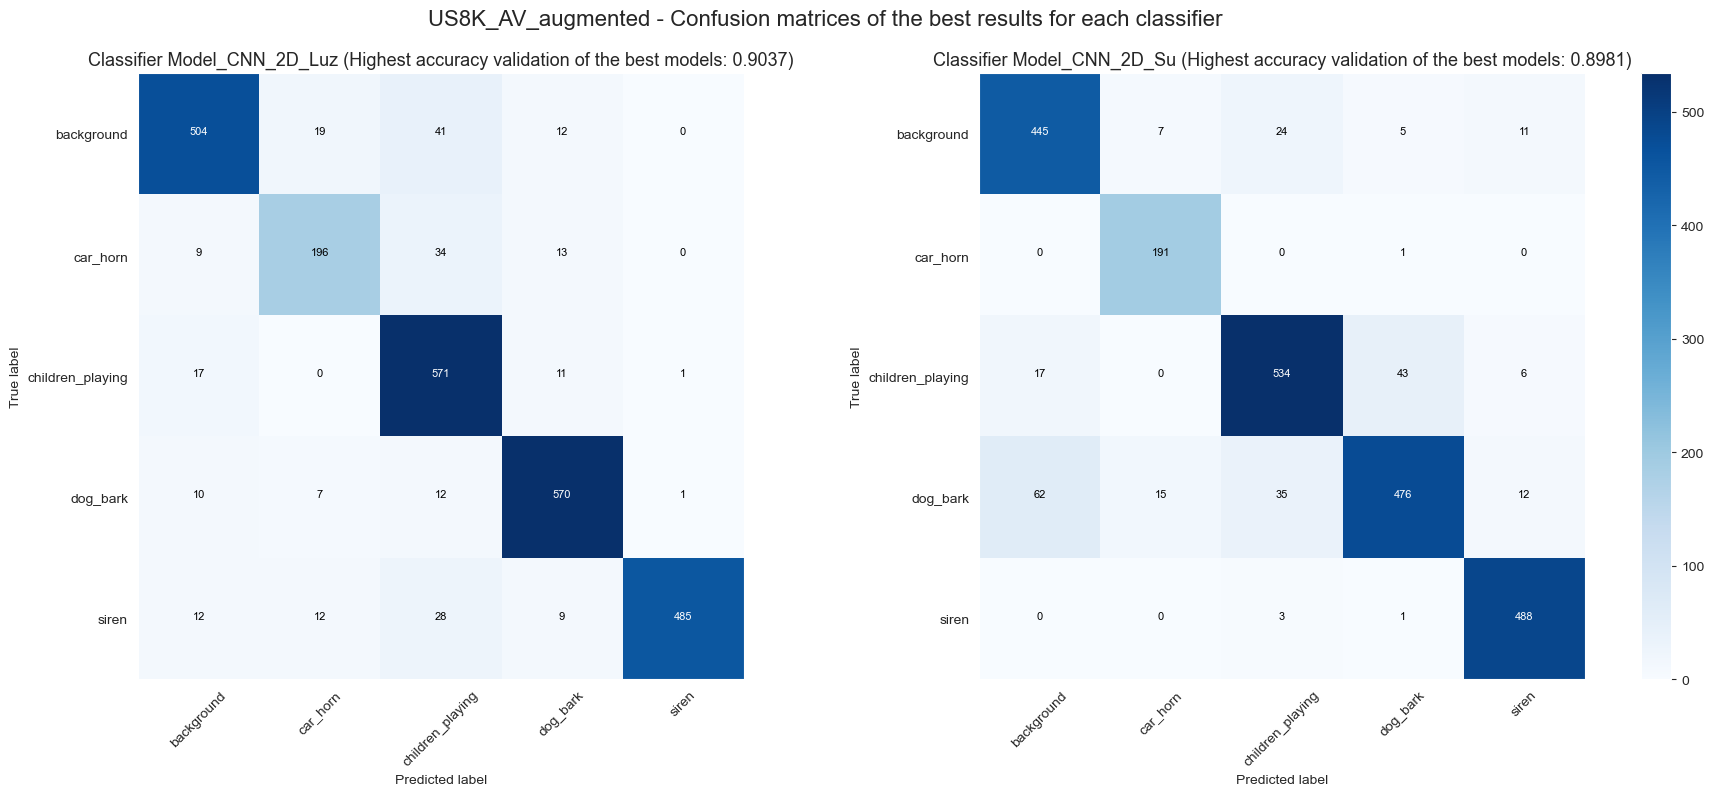

In [63]:
# Plot the confusion matrix for the highest accuracy test classifiers

picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(20,8))
plt.suptitle(nom_dataset + model_surname + ' - Confusion matrices of the best results for each classifier', fontsize = 16,  y=0.99)
for i, idx in zip(conf_matrices_dict.keys(), range(1, len(conf_matrices_dict) + 1)):
    title = 'Classifier '+ i + ' (Highest accuracy validation of the best models: ' + str("{:0.4f}".format(conf_matrices_dict[i]['Accuracy(Val)'])) +')'
    plt.subplot(1,2,idx)
    plot_confusion_matrix(conf_matrices_dict[i]['Conf_M'],  
                          nom_classes, 
                          title,
                          cmap = None,                          
                          normalize = False)

plt.savefig(os.path.join(path_pic, picture_name))
plt.tight_layout()

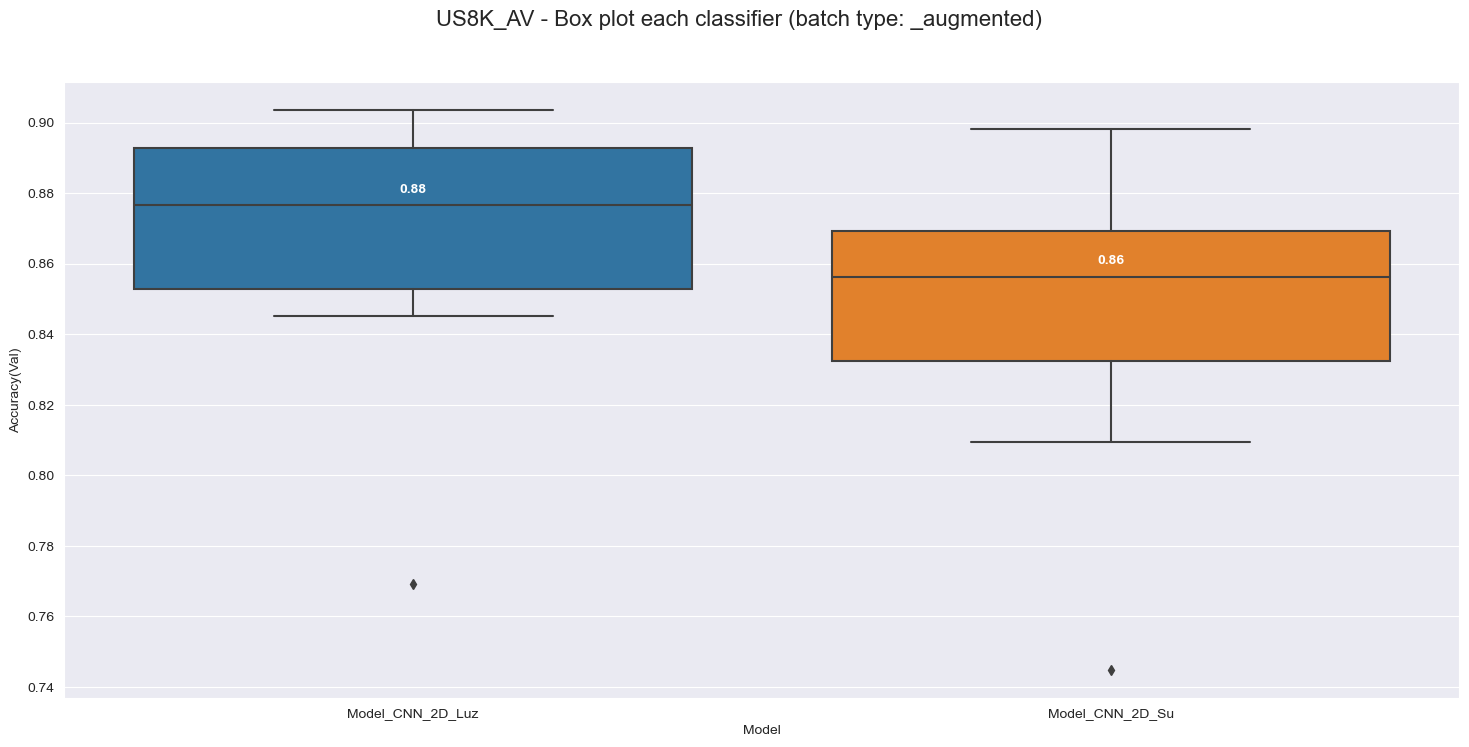

In [64]:
picture_name = f'{pic_first_name}{get_next_file_number(path_pic):02d}.png'

plt.figure(figsize=(18,8))
plt.suptitle(f'{nom_dataset} - Box plot each classifier (batch type: {model_surname})', fontsize = 16,  y=0.97)
box_plot = sns.boxplot(data=metrics_set, x="Model", y="Accuracy(Val)", showfliers = True)

medians = list(metrics_set.groupby(['Model'])['Accuracy(Val)'].median())
medians = [round(element, 2) for element in medians]

vertical_offset = metrics_set['Accuracy(Val)'].median()*0.0001  # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick, medians[xtick] + vertical_offset, medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')
plt.savefig(os.path.join(path_pic, picture_name))

# End of the notebook